# Studienarbeit: Machine Learning
#### Saniye Ogul und Johannes Horst

# Gliederung

* [1. Analyse des Datensatz](#Analyse-des-Datensatz)
    * [1.1 Visualisierung der Betriebszeiten](#Visualisierung-der-Betriebszeiten)
    * [1.2 Korrelation der Daten mit Fehlern](#Korrelation-der-Daten-mit-Fehlern)
    * [1.3 Visualisierung Aller Daten](#Visualisierung-aller-Daten)

* [2. Aufgabe 1](#Aufgabe-1-(Klassifikation-des-Systemzustands-))
    * [2.1 Feature Engineering](#featureEng)
    * [2.2 Maßnahmen und Techniken für eine bessere Güte der Modelle](#hyper)
    * [2.2 Feature Importances Fourier](#eval1_F_imp)
    * [2.3 Feature Importances Sliding Window](#eval1_S_imp)
    * [2.4 Aufgabe 1 Fazit](#fazit1)

* [3. Aufgabe 2](#aufgabe2)
    * [3.1 1 Stunde Vorhersage](#aufgabe2_1h)
    * [3.2 Vergleich verschiedener Vorhersagezeiträume](#aufgabe2_vgl)
    * [3.3 Aufgabe 2 Fazit](#aufgabe2_fazit)

* [4. Aufgabe 3](#aufgabe3)
    * [4.1 Annäherung der verbleibenden Zeit mit Regression](#aufgabe3_regresion)
    * [4.2 Regression Ergebnisse](#aufgabe3_regression_res)
    * [4.3 Annäherung der verbleibenden Zeit mit Klassifikation](#aufgabe3_clf)
    * [4.4 Klassifikation Ergebnisse](#aufgabe3_clf_res)
    * [4.5 Aufgabe 3 Fazit](#aufgabe3_fazit)

* [5. Aufgabe 4](#aufgabe4)
    * [5.1 Ergebnisse](#aufgabe4_res)
    * [5.2 Aufgabe 4 Fazit](#aufgabe4_fazit)

* [6. Aufgabe 5](#aufgabe5)
    * [6.1 GaussianMix auf Fourier Transformation](#aufgabe5_gm_a)
    * [6.2Auswahl der Signifikanten Frequenzen](#aufgabe5_select)
    * [6.2 Ergebnisse](#aufgabe5_res)
    * [6.3 Aufgabe 5 Fazit](#aufgabe5_fazit)

* [Quellenverzeichniss](#src)

### Imports
- plotly
- matplotlib
- pandas
- numpy
- scikit-learn

In [120]:
# Importe
import pandas as pd
import numpy as np
import plotly.express as px
from collections import Counter
from matplotlib.dates import DateFormatter
import datetime as dt
from pandas import DataFrame
import math
from collections import Counter
import warnings

#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#Import Trainingmodel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, recall_score
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
import multiprocessing

#### Analyse des Datensatz

In [121]:
def to_time(s, fmat="%d-%m-%y %H:%M"): return dt.datetime.strptime(s, fmat)

def get_err(df, e, td_before=None, td_after=None): 
    dt_start = e[0]
    if td_before: dt_start = dt_start - td_before
        
    dt_end = e[1]
    if td_after: dt_end = dt_end + td_after
        
    return df.loc[(df["timestamp"] >= dt_start) & (df["timestamp"] < dt_end)]

In [122]:
ERRORS = [
#    Start,             Ende,              Fehlernummer
    (to_time("28-02-22 21:53"), to_time("01-03-22 02:00"), 1),
    (to_time("23-03-22 14:54"), to_time("23-03-22 15:24"), 2),
    (to_time("30-05-22 12:00"), to_time("02-06-22 06:18"), 3),
]

E1 = ERRORS[0]
E2 = ERRORS[1]
E3 = ERRORS[2]

In [123]:
def read_data_withLables():
    df = pd.read_csv('dataset_train.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    #df.set_index("timestamp", verify_integrity=True, inplace=True)

    exclude = ["gpsLong", "gpsLat", "gpsSpeed", "gpsQuality"]
    df = df[[c for c in df.columns if c not in exclude]]

    df["Error"] = 0
    for e_start, e_end, e_nr in ERRORS: df.loc[(df["timestamp"] >= e_start) & (df["timestamp"] < e_end), "Error"] = e_nr
    df["isError"] = df["Error"] != 0
    return df

df = read_data_withLables()

##### Visualisierung der Betriebszeiten

In [124]:
delta = dt.timedelta(seconds=1)

s = (df['Error'].diff(1)!= 0) | (df['timestamp'].diff(1) > delta)

#split into slices
df_slices = df.copy()
df_slices['slice'] = s.cumsum()
df_slices["date"] = df_slices["timestamp"].dt.date
df_slices["time"] = pd.to_datetime("05.02.2022 " + df_slices["timestamp"].dt.time.astype(str) , format="%d.%m.%Y %H:%M:%S")
df_slices = df_slices.groupby("slice").agg({"timestamp" : ["first", "last"], "date" : ["first"], "time" : ["first"], "Error" : ["first"]})
df_slices.columns = [' '.join(c) for c in df_slices.columns.values]
df_slices["timedelta"] = df_slices["timestamp last"] - df_slices["timestamp first"] 
df_slices["time last"] = df_slices["time first"] + df_slices["timedelta"]
df_slices["text"] = df_slices["timestamp first"].dt.strftime("%d.%m.%Y %H.%M.%S") + " - " + df_slices["timestamp last"].dt.strftime("%d.%m.%Y %H.%M.%S")                             


In [125]:
px.timeline(df_slices, x_start="time first", x_end="time last", y="date first", color="Error first", height=1200, hover_name="text")

Die obige Abbildung zeigt die Betriebszeiten, an der y-Achse sind die Tage aufgezeigt und auf der x-Achse die Betriebszeit.
Die Fehler wurden farbig hervorgehoben.

In [126]:
#make some space on ram
del [[df_slices]]

##### Korrelation der Daten mit Fehlern

In [127]:
ft_cols = [c for c in df.columns if c not in ["timestamp", "isError", "Error", "start_stop"]]
df_corr_ft = df[ft_cols].copy()
df_corr_lb = df[["Error", "isError"]].copy()

df_corr_lb["IsError1"] = df_corr_lb["Error"] == 1
df_corr_lb["IsError2"] = df_corr_lb["Error"] == 2
df_corr_lb["IsError3"] = df_corr_lb["Error"] == 3

df_corr = pd.DataFrame({e:df_corr_ft.corrwith(df_corr_lb[e]) for e in ["isError", "IsError1", "IsError2", "IsError3"]})

In [128]:
px.bar(df_corr.unstack().reset_index(), x="level_1", y=0, color="level_0", barmode="group")

Die obere Abbildung zeigt die die Korrelation der einzelnen Sensordaten zu den Fehlern.

Die 3 Aussagekräftigsten Sensoren für jeden Fehler sind:

In [129]:
eralg = df_corr["isError"].abs().sort_values(ascending=False)
er1 = df_corr['IsError1'].abs().sort_values(ascending=False)
er2 = df_corr['IsError2'].abs().sort_values(ascending=False)
er3 = df_corr['IsError3'].abs().sort_values(ascending=False)

print(f'Fehler 1: \n{er1[:3]}\n\nFehler 2: \n{er2[:3]}\n\nFehler 3: \n{er3[:3]}\n\nAllgemein: \n{eralg[:3]}')

Fehler 1: 
LPS                0.357046
TP3                0.212710
Oil_temperature    0.120653
Name: IsError1, dtype: float64

Fehler 2: 
Reservoirs         0.003368
Oil_temperature    0.003248
LPS                0.001028
Name: IsError2, dtype: float64

Fehler 3: 
Reservoirs         0.144370
Oil_temperature    0.044362
Motor_current      0.013031
Name: IsError3, dtype: float64

Allgemein: 
Reservoirs    0.115827
LPS           0.084777
TP3           0.059212
Name: isError, dtype: float64


##### Visualisierung aller Daten

In [130]:
# a function that plots every column in a dataframe in a single plot using matplotlib in subplots
def plot_df_all_columns(df, start, end):
    # Create a new dataframe with the data between start and end timestamps
    mask = (df['timestamp'] > start) & (df['timestamp'] <= end)
    df_plot = df.loc[mask]
    # Create a matplotlib figure
    fig, axs = plt.subplots(df_plot.columns.size, 1, figsize=(20, 40))

    i = 0
    for col in df_plot.columns:
        axs[i].plot(df_plot['timestamp'], df_plot[col])
        axs[i].set(xlabel='timestamp', ylabel=col, title=col)
        #display 20 x-axis labels
        axs[i].xaxis.set_major_locator(plt.MaxNLocator(20))
        axs[i].grid()
        formatter = DateFormatter('%H:%M:%S')
        fig1 = plt.gcf()
        fig1.axes[0].xaxis.set_major_formatter(formatter)
        i = i + 1

    fig.tight_layout()
    plt.show()

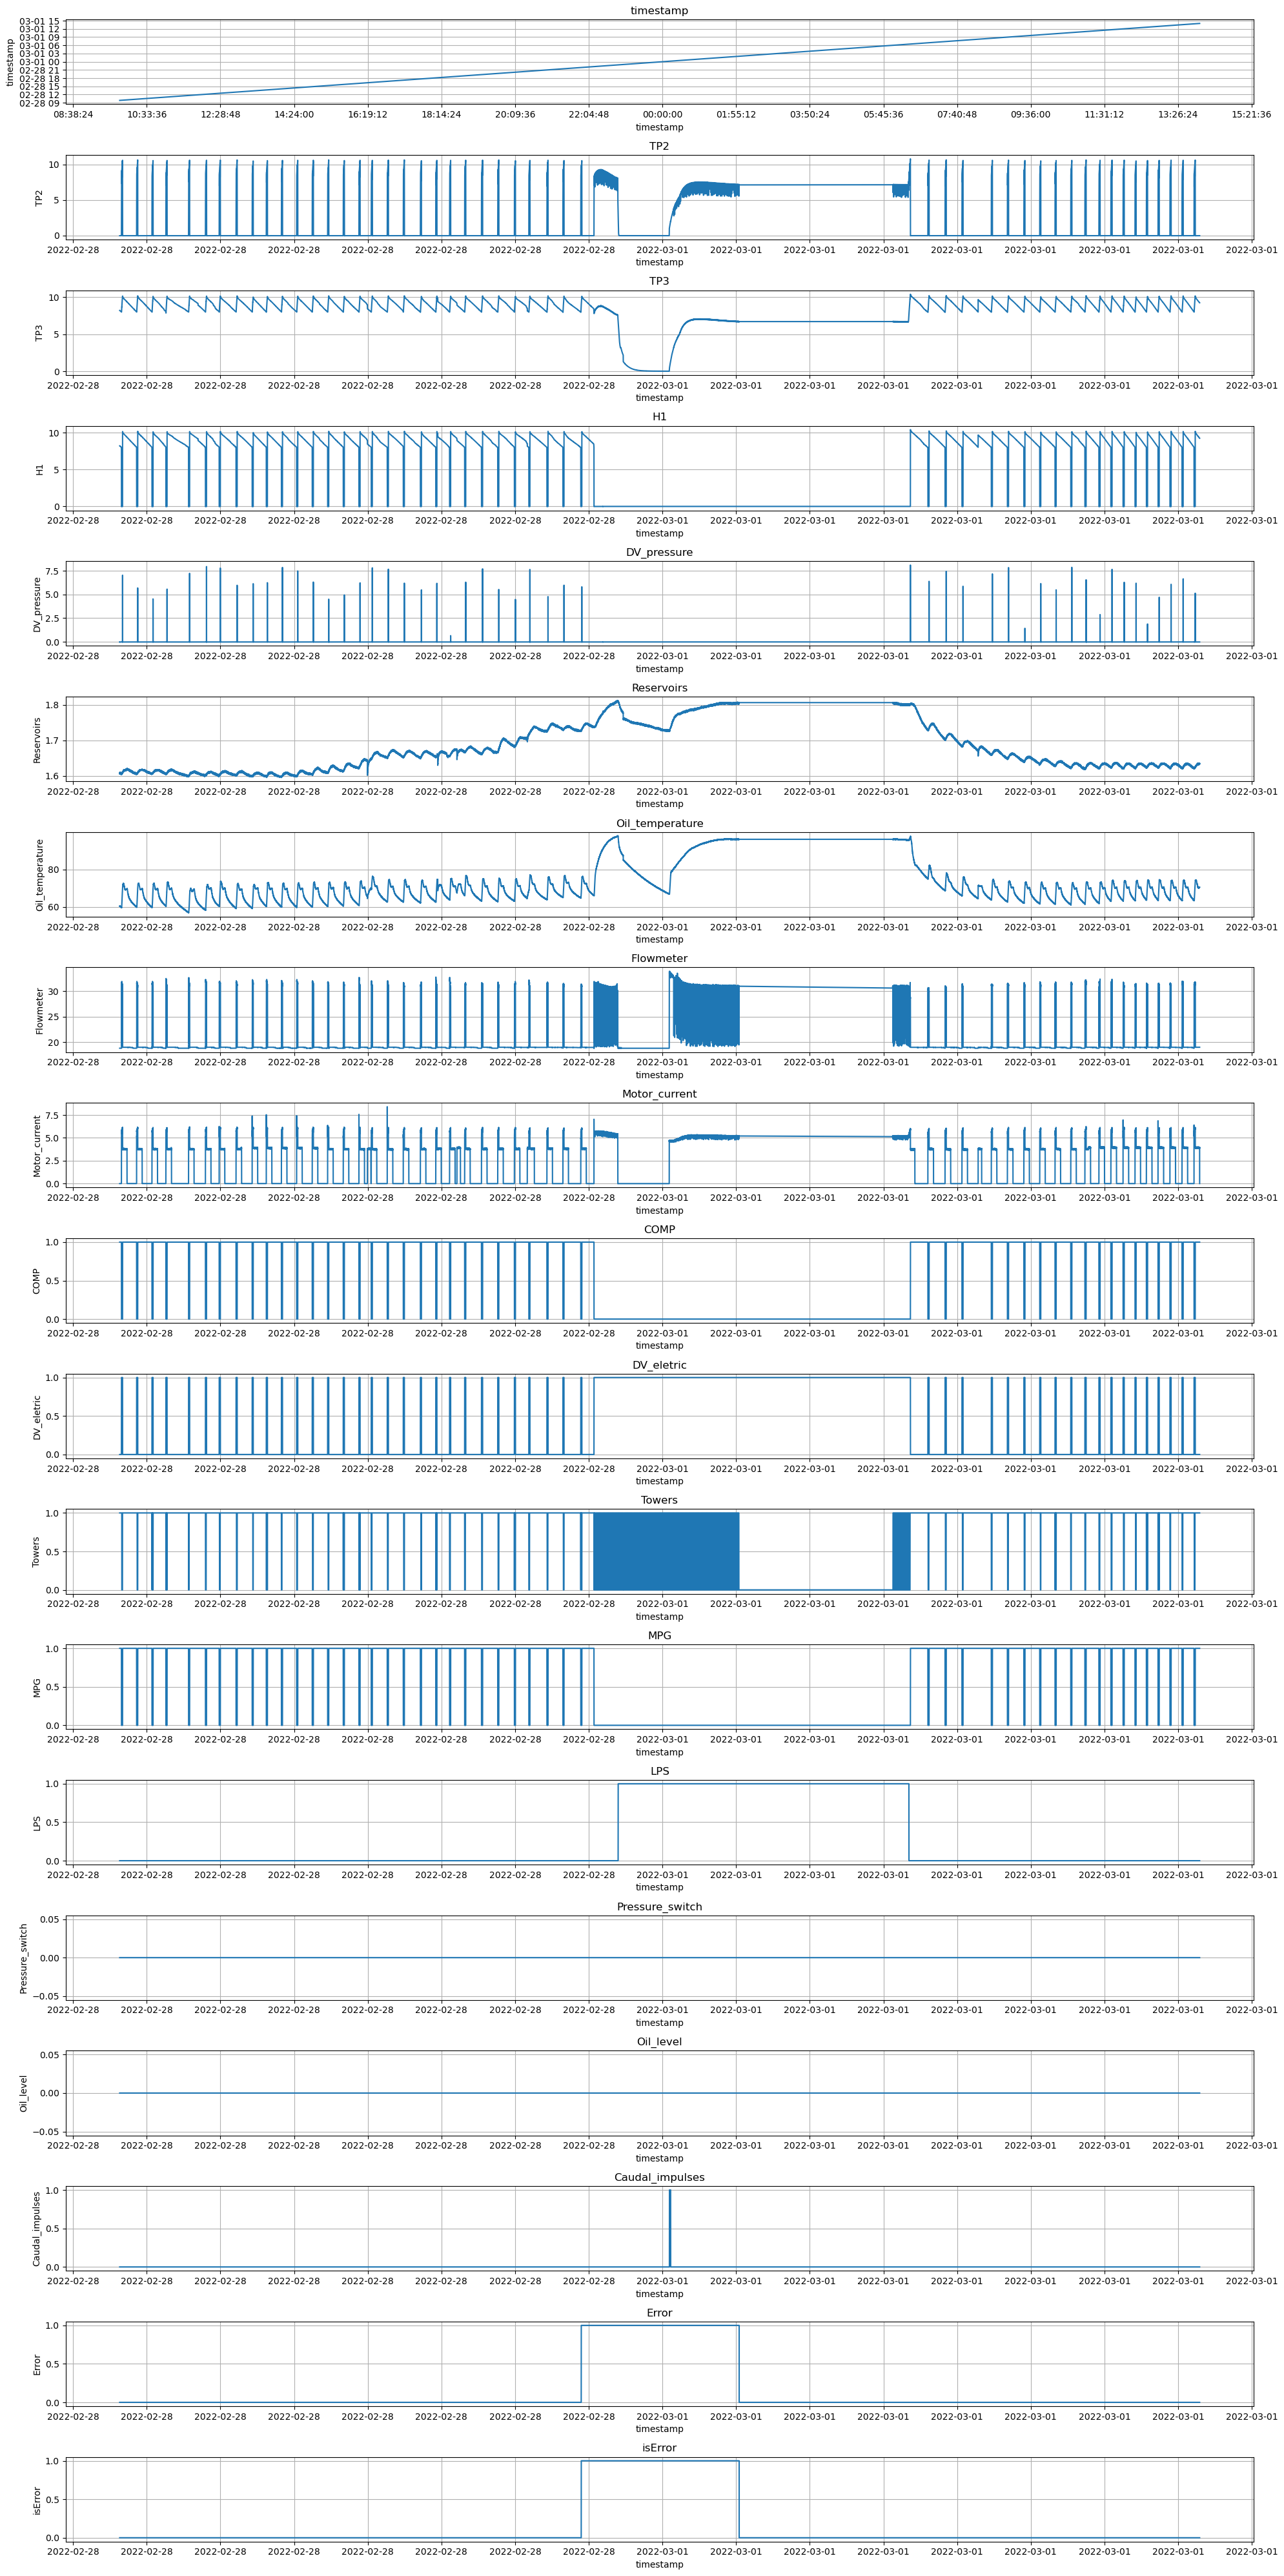

In [131]:
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

s = err_1_start - dt.timedelta(hours=3*4, seconds=100)
e = err_1_end + dt.timedelta(hours=3*4)
plot_df_all_columns(df, s, e)

# Aufgabe 1 (Klassifikation des Systemzustands)
    Erstellung eines binären Klassifikationsmodell zur Vorhersage des aktuellen Zutands der APU (Air Production Unit) auf Basis der Sensordaten. Soll differenziert werden ob APU in Ordnung oder nicht ist (binäre Klassifikation)
    zu verwendene Verfahren:
    - einen nicht-parametrisierten Modellansatz,
    - einen parametrisierten Modellansatz,
    - ein Verfahren aus dem Bereich des Ensemble Learning.

    Trainigsdatensatz erstellen z.B. durch geeignete Datentransformationen, Feature Engineering und ggf. Feature Extraction. Sequentielle Struktur der Daten soll berücksichtigt werden.
    Wenden Sie zur Modellerstellung (in dieser und den folgenden Aufgaben) geeignete Maßnahmen und Techniken an, damit die resultierenden Modelle eine moglichst hohe Gute aufweisen und beurteilen Sie diese anhand geeigneter Kriterien. Modularisieren und automatisieren Sie Ihren Workflow, damit die einzelnen Schritte in den folgenden Aufgaben ggf.
    wiederverwendet werden konnen. Achten Sie darauf, dass Ihre Modelle auf unbekannte Daten angewendet werden konnen, die ggf. fehlende Werte enthalten, auch wenn der gegebene Datensatz keine fehlenden Werte enthalt. Welche Features erweisen sich als besonders aussagekräftig für die gegebene Aufgabenstellung?

In [132]:
# Daten einlesen
df = pd.read_csv('dataset_train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Zeiterfassung der Störungsfälle (für eigene Labels)
**Fall 1:**
- 28.2-1.03: 22:12:00 - 6:27:00

**Fall 2:**
- 24.03: 11:15:00 - 15:08:00

**Fall 3:**
- 30.05-02.06: 04:00:00 - 07:40:00 



In [133]:
#set labels for errors again in single column
df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)


<a id='featureEng'></a>

### Feature Engineering

---

#### Ansatz Sliding Window:

Die Fehlererkennung in diesem Projekt wird nicht auf Basis der Sensorwerte zu einem bestimmten Zeitpunkt, sondern durch die Analyse von Sensorwerten über einen Zeitraum durchgeführt. Um dies zu erreichen, werden die Sensorwerte in Zeitfenstern aggregiert und als Merkmale verwendet. Diese Zeitfenster werden so gewählt, dass sie Fehler erkennen können.

Jedes Zeitfenster wird in Bezug auf die Sensorwerte untersucht, um die verschiedenen Verhaltensmuster der Sensoren in den Zeitfenstern bestmöglich zu repräsentieren. Hierfür werden die Werte Minimum, Maximum, Standardabweichung, Varianz und Durchschnitt für jeden Sensor berechnet. Die Berechnung des Minimums und Maximums ermöglicht es, die Veränderungen der Amplitude eines periodischen Sensorsignals zu erkennen. Die Standardabweichung gibt Auskunft über die Schwankungen eines Sensors in einem Zeitfenster.

Bei der Auswahl der Größe des Zeitfensters muss sichergestellt werden, dass es weder zu groß noch zu klein ist. Das Label eines Zeitfensters wird auf Basis der Anzahl der fehlerhaft markierten Datensätze bestimmt. Beispielsweise, bei 40 fehlerhaft markierten Datensätzen und 10 nicht fehlerhaften Datensätzen in einem Zeitfenster, würde das Label 1 sein.

Es ist wichtig, dass beim Einsatz des "Sliding Window" Ansatzes keine Informationen von den Trainingsdaten in die Testdaten übertragen werden. Daher wird das Zeitfenster nicht um einen Datensatz, sondern um die Fenstergröße selbst verschoben, um in jedem Zeitfenster immer neue Datensätze zu haben. Ein zufälliger Train-Test-Split nach der Anwendung des Sliding Windows, könnte ansonsten zu Overfitting führen, da die Testdaten dann zu einem großen Teil mit den Trainingsdaten übereinstimmen würden.

---

#### Ansatz Fourier Transformation:

Die Fourier-Transformation ist ein klassisches Instrument in der Signalverarbeitung und ermöglicht die Analyse von Zeitreihen-Signalen in Bezug auf ihre Frequenzkomponenten. Es handelt sich dabei um eine lineare Transformation, die eine zeitkontinuierliche Funktion in eine Summe von sinus- und cosinusförmigen Funktionen umwandelt. Die Fourier-Transformation ist dabei überall dort hilfreich, wo es darum geht, zyklische Muster in Signalen zuerkennen und zu charakterisieren.

In unserem Projekt haben wir die Fourier-Transformation als Feature Engineering-Maßnahme eingesetzt. Durch die Transformation in die Frequenzen können Abweichungen von periodischen Signalen besser repräsentiert werden. 

Ähnlich wie beim Ansatz des Sliding Window, werden auch hier wieder einzelne Zeitfenster betrachtet. 
Allerdings eignet sich die Fourier Transformation nicht auf alle Sensorwerte, da diese nicht periodisch sind. Daher haben wir uns für die Anwendung auf die folgenden Sensoren entschieden: **Oil_temperature**, **TP3**, **Reservoirs**, **Motor_current**, **H1**.

Außerdem wird für die Fourier Transformation ein Hanning Window eingesetzt.

<img src="https://im.contentlounge.net/styles/manual_crop/s3/signal-mit-hanning-windowing_719e58d2.png?im=AspectCrop%2Csize%3D%2816%2C9%29%2Cgravity%3DCenter%2CallowExpansion%2CBackgroundColor%2Ccolor%3Dtransparent&hash=3c752de55921cadc451b84d615ccf210f917202726db7136bc6cd9a1474c8269" width="500"> [[1]](#src)

Das Hanning Window dient dazu, Abruptheiten im Signal am Anfang und am Ende abzufedern. Hierbei werden abrupte Übergänge ausgeglichen, die durch eine nicht exakte Erfassung einer Periode des Signals oder durch einen Anfangswert, der stark von dem letzten Wert des vorherigen Fensters abweicht, entstehen könnten. Es ist jedoch zu beachten, dass bei der Verwendung des Hanning Windows Informationen am Rand des Fensters geglättet werden, wodurch sie ein geringeres Gewicht erhalten und teilweise verloren gehen können. Diese Maßnahme ist jedoch erforderlich, um brauchbare Informationen aus der Fourier-Transformation zu erhalten.

Um andere relevante Sensoren in den Datensatz mit aufzunehmen wurde sich für die Sensoren **LPS** und **DV_pressure** eigene Methoden überlegt um die Werte in dem Fenster bestmöglich zu repräsentieren.

* **LPS**: Berechnen des Durchschnitts. LPS ist ein digitaler Sensor und liefert lediglich 0 oder 1. Durch den Durchschnitt wird ausgedrückt, wie lange der Sensor auf 1 in dem jeweiligen Fenster war.

* **DV_pressure**: Zählen der Spitzen. DV_Pressure ist ein analoger Sensor und liefert die meiste Zeit den wert 0. Allerdings springt der Wert sporadisch für kurze Zeit auf 1. Die Informationen dieses Sensors besteht aus der Anzahl der Spitzen in dem jeweiligen Fenster. Eine spitze wird gezählt, wenn der Wert 0,5 überschreitet.

Eine Einschränkung, die diese Methode bietet ist jedoch, dass die Fenstergröße nicht zu klein gewählt werden darf. Die Fenstergröße bestimmt die gleichzeitig darstellbaren Frequenzen. Je kleiner die Fenstergröße, desto weniger Frequenzen können dargestellt werden.

---
##### PCA:
PCA (Principal Component Analysis) ist eine Technik, die wir für das Feature Engineering ausprobiert haben. Diese Technik reduziert die Daten auf weniger Dimensionen. Außerdem ermöglicht es Spalten anhand einer Mindest-Varianz (in Prozent) zusammenzuführen. Wichtig hierbei zu beachten ist, dass je niedriger der Prozentanteil ist, desto mehr Daten können zusammengefasst werden und somit liegen weniger Merkmale vor. Bei einem höheren Anteil bleiben auch mehr Merkmale erhalten. Wenn die Anzahl an Merkmalen zu gering ist, kann es schwieriger werden, die Modelle auf den Daten zu trainieren. Es gibt dann weniger Informationen über die Daten, auf die sich das Modell stützen kann. Ein Modell benötigt genügend Merkmale, um ein möglichst präzises Muster in den Daten zu erkennen und zu lernen, die es auf neue Daten anwenden soll. 

Mit der Anwendung von PCA hofften wir auf eine Verbesserung der Ergebnisse beim Trainieren der Modelle und bessere Performance. Letztendlich lieferte PCA in unserem anwenugsfall leider nur enie leichte verschlechterung der Ergebnisse. Deshalb wurde auf die Anwendung von PCA verzichtet.

---


##### Scaling der Daten:

Der Zweck des Scaling bei den Daten besteht darin, eine einheitliche Skala zu schaffen, damit die Lernalgorithmen effektiv trainiert werden können. Hierbei wird ein MinMaxScaler eingesetzt, der die Werte eines Merkmals in einen bestimmten Wertebereich transformiert, von 0 bis 1. Dies minimiert extreme Ausreißer in den Daten und garantiert, dass jedes Merkmal gleichmäßig gewichtet wird.

Die Funktion "scale" in der Klasse "MetroBinaryClassifier" implementiert die Skalierung auf den Trainingsdaten und speichert den Scaler, sodass dieser für die Predict Funktionen wieder verwendet werden kann. Anschließend werden sowohl die Trainings- als auch die Testdaten mit dem Scaler transformiert, um eine einheitliche Darstellung der Daten zu gewährleisten.

Dieses Scaling-Verfahren wird in Kombination mit dem Sliding Window-Verfahren verwendet, um ein besseres Ergebnis zu erzielen.

---

In beiden Fällen werden alle GPS Werte und der Timestamp als Features ignoriert. GPS Werte werden ignoriert, um die Fehler nicht in Abhängigkeit zu der Position zu bringen. Der Timestamp wird aus dem gleichen Grund ignoriert, es soll keine Abhängigkeit zwischen Fehlern und Zeitpunkt entstehen.

---

### Auswahl der Modelle

Die oben beschriebenen Methoden der Datenvorbereitung wurden auf mehrere Modelle angewendet. Diese sind auch noch in der Klasse **MetroBinaryClassifier** zu finden. Im Folgenden werden nur die besten Modelle aus den Bereichen parametrisiert, parametrisiert und Ensemble Learning verglichen. (Random Forest, Decision Tree, Logistic Regression)


Für die Implementierung der binären Klassifikation in unserem Projekt haben wir drei verschiedene Ansätze verwendet:
-  nicht-parametrischen Modellansatz = Decision Tree
-  parametrischen Modellansatz = Logistic Regression
-  Ensemble Learning-Verfahren = Random Forest


In [134]:
class FeatureGeneration:
    """
    Class for feature generation
    """

    def yfft(self, y):
        """
        Compute the yFFT of a signal. Applys a Hanning window to the signal.

        Parameters
        ----------
        y : array
            Signal

        Returns
        -------
        yfft : array
            yFFT
        """
        hanning = np.hanning(len(y))
        yf = 4*np.abs(np.fft.rfft(y*hanning))/len(y)
        return yf

    def xfft(self, blocksize, duration):
        """
        Compute the xFFT of a signal

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        duration : float
            Duration of a block in seconds

        Returns
        -------
        xfft : array
            xFFT
        """
        return np.fft.rfftfreq(blocksize, duration)

    def fourier(self, blocksize, max_freq, series, name):
        """
        Compute the Fourier transform of a signal

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        max_freq : float
            Maximum frequency to consider
        series : array
            Signal
        name : str
            Name of the signal

        Returns
        -------
        df : DataFrame
            Fourier transform
        """

        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        X_f = self.xfft(blocksize, 1)
        X_f = X_f[X_f<max_freq]
        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]
            # iserr    = df_block['Label'].sum() > BLOCKSIZE/2
            fft_amp  = self.yfft(sr_block)[:len(X_f)]
            # block_data = {'iserr': iserr}
            data.append({f'{name}_{j}':amp for j,amp in enumerate(fft_amp)})

        return pd.DataFrame(data)

    def getError(self, blocksize, series, name, label_most_common=True):
        """
        Compute the errors of a series in blocks

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        series : array
            Error Series
        name : str
            Name of the Error column in the resulting DataFrame
        label_most_common : bool, optional
            If True, the most common value in the block is used as label. If False, the mean is used. The default is True.

        Returns
        -------
        df : DataFrame
            Error Series
        """
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            #iserr    = sr_block.sum() > blocksize/2
            if(label_most_common):
                iserr = Counter(sr_block).most_common(1)[0][0]
            else:
                iserr = sr_block.mean()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':iserr})

        return pd.DataFrame(data)

    def getMean(self, blocksize, series, name):
        """
        Compute the mean of a series in blocks

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        series : array
            Series
        name : str
            Name of the column in the resulting DataFrame

        Returns
        -------
        df : DataFrame
            Mean Series
        """
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            mean    = sr_block.mean()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':mean})

        return pd.DataFrame(data)

    def countPeaks(self, blocksize, series, name):
        """
        Compute the number of peaks of a series in blocks

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        series : array
            Series
        name : str
            Name of the column in the resulting DataFrame

        Returns
        -------
        df : DataFrame
            Number of peaks
        """
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            count    = sr_block[sr_block > 0.5].count()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':count})

        return pd.DataFrame(data)

    def getFeatures(self, df, blocksize = 700, max_freq = 1000, label_most_common = True):
        """
        Compute the features of a DataFrame

        Parameters
        ----------
        df : DataFrame
            DataFrame containing the signals
        blocksize : int, optional
            Number of samples in a block. The default is 700.
        max_freq : int, optional
            Maximum frequency to consider. The default is 1000.
        label_most_common : bool, optional
            If True, the most common value in the block is used as label. If False, the mean is used. The default is True.

        Returns
        -------
        df_features : DataFrame
            DataFrame containing the features
        """
        df_features = pd.DataFrame()

        blocks = blocksize

        tp3 = self.fourier(blocks,max_freq, df['TP3'], 'TP3')
        oil = self.fourier(blocks, max_freq, df['Oil_temperature'], 'Oil')
        res = self.fourier(blocks, max_freq, df['Reservoirs'], 'Res')
        motCurr = self.fourier(blocks, max_freq, df['Motor_current'], 'MotCurr')
        h1 = self.fourier(blocks, max_freq, df['H1'], 'H1')
        LPS = self.getMean(blocks, df['LPS'], 'LPS')
        DV_pressure_peaks = self.countPeaks(blocks, df['DV_pressure'], 'DV_pressure_peaks')

        errors = self.getError(blocks, df['Label'], 'Error', label_most_common)

        df_features = pd.concat([df_features, tp3, oil,errors, res, motCurr, h1, LPS, DV_pressure_peaks], axis=1)
        return df_features

In [135]:
class MetroBinaryClassifier:
    """
    Class for the binary classification of metro data

    Parameters
    ----------
    use_shortened : bool, optional
        If True, the shortened dataset is used. The default is False.

    n_components : float, optional
        Number of components to keep in the PCA. The default is 0.95.

    window_size : int, optional
        Size of the window for the rolling operations. The default is 60.

    test_size : float, optional
        Size of the test set. The default is 0.3.

    random_state : int, optional
        Random state for all random_state operations. The default is 0.

    max_depth : int, optional
        Maximum depth of the decision tree. The default is 7.

    min_samples_leaf : int, optional
        Minimum number of samples in a leaf. The default is 10.

    excluded_columns : list, optional
        List of columns to exclude from the dataset. The default is []. 
    """

    def __init__(self, use_shortened: False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=[]):
        self.n_components = n_components
        self.windowSize = window_size
        self.test_size = test_size
        self.random_state = random_state
        self.excluded_columns = excluded_columns
        self.use_shortened = use_shortened

        self.scaler = None
        self.pca = None

        self.feature_columns = None

        #Dataset:
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

        #classifiers
        self.decision_tree = None
        self.random_forest = None
        self.linear_SVM = None
        self.naive_bayes = None
        self.linear_discriminant_analysis = None

        #regressions
        self.polyreg_scaled = None
        self.logistic_regression = None
        self.linear_regression = None


    def prepareFourier(self, data: DataFrame, blocksize = 700, max_freq = 1000, stratify = True, label_most_common = True):
        """
        Prepare the data with the Fourier transform

        Parameters
        ----------
        data : DataFrame
            DataFrame containing the signals
        blocksize : int, optional
            Number of samples in a block. The default is 700.
        max_freq : int, optional
            Maximum frequency to consider. The default is 1000.
        stratify : bool, optional
            If True, the train and test sets are stratified. The default is True.
        label_most_common : bool, optional
            If True, the most common value in the block is used as label. If False, the mean is used. The default is True.
        """

        #drop all nan values
        data = data.dropna()

        featureGenerator = FeatureGeneration()
        df_features = featureGenerator.getFeatures(data, blocksize = blocksize, max_freq = max_freq, label_most_common = label_most_common)
        X = df_features.drop('Error', axis=1)
        y = df_features['Error']

        s = None
        if stratify:
            s=y


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=s)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        return X_train, X_test, y_train, y_test
        


    def sliding_window(self, data: DataFrame, window_size = 60, step_size=None, label_func = None, excluded_columns = ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']):
        """
        Creates a sliding window of size window_size for each column in data.
        Performs the following operations on each column:
        - mean
        - std
        - min
        - max

        Parameters
        ----------
        data : DataFrame
            The DataFrame that should be transformed.

        window_size : int, optional
            The size of the sliding window. The default is 60.

        excluded_columns : list, optional
            A list of columns that should be excluded from the sliding window. The default is ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'].

        Returns
        -------
        df_rolling : DataFrame
            The transformed DataFrame.
        """
        columns = data.columns
        columns  = [x for x in columns if x not in excluded_columns]
        operations = ['mean', 'std', 'min', 'max', 'var']
        if(step_size == None):
            step_size = window_size

        #generate a dict, where the keys are the column names and the values are the operations that should be performed on the column
        operations_dict = {}
        for column in columns:
            operations_dict[column] = operations

        def mostFrequent(row):
            return Counter(row).most_common(1)[0][0]

        if(label_func == None):
            operations_dict['Label'] = [mostFrequent]
        else:
            operations_dict['Label'] = [label_func]

        df_rolling = data.rolling(window_size,center=True,step=window_size).agg(operations_dict)

        #drop all columns that have NaN values
        df_rolling = df_rolling.dropna()

        #flatten df_rolling
        df_rolling.columns = ['_'.join(col) for col in df_rolling.columns]

        #rename Label_<opaeration> to Label
        if(label_func == None):
            df_rolling = df_rolling.rename(columns={'Label_mostFrequent': 'Label'})
        else:
            name = "Label_"
            #check if the label_func is a string
            if(isinstance(label_func, str)):
                name += label_func

            #check if the label_func is a function
            elif(callable(label_func)):
                name += label_func.__name__

            #if the label_func is neither a string nor a function, raise an exception
            else:
                raise Exception("label_func is not a string or a function")

            df_rolling = df_rolling.rename(columns={name: 'Label'})
        
        return df_rolling

    
    def scale(self, train, test):
        """
        Scale the data using StandardScaler
        Fits the scaler on the training data and transforms the training and test data.

        Parameters
        ----------
        train : DataFrame
            The training data.

        test : DataFrame
            The test data.

        Returns
        -------
        train_rescaled : DataFrame
            The rescaled training data.
        """
        self.scaler = MinMaxScaler()
        train_rescaled = self.scaler.fit_transform(train)
        test_rescaled = self.scaler.transform(test)

        return train_rescaled, test_rescaled
    
    def performPca(self, train, test):
        """
        Perform PCA on the data.
        Fits the PCA on the training data and transforms the training and test data.
        This is done to reduce the dimensionality of the data.
        This will slightly reduce the accuracy of the model, but will increase the speed of the model.
        Uses the n_components parameter given by in the constructor of the class to determine the number of components.
        (if a float is given, the number of components is determined by the explained variance)

        Parameters
        ----------
        train : DataFrame
            The training data.

        test : DataFrame
            The test data.

        Returns
        -------
        train_pca : DataFrame
            The PCA transformed training data.

        test_pca : DataFrame
            The PCA transformed test data.
        """
        self.pca = PCA(n_components=self.n_components,random_state=self.random_state)
        train_pca = self.pca.fit_transform(train)
        test_pca = self.pca.transform(test)

        return train_pca, test_pca

    
    def prepareData(self, dataFrame, do_scale=True, do_pca=True,do_sliding=True, label_func=None):
        """
        Prepare the data for the model.
        This includes(if desired):
        - sliding window
        - scaling
        - PCA

        Parameters
        ----------
        dataFrame : DataFrame
            The DataFrame that should be prepared.

        do_scale : bool, optional
            Whether the data should be scaled. The default is True.

        do_pca : bool, optional
            Whether PCA should be performed on the data. The default is True.

        Returns
        -------
        X_train : DataFrame
            The training data.

        X_test : DataFrame
            The test data.

        y_train : DataFrame
            The training labels.

        y_test : DataFrame
            The test labels.
        """

        data = dataFrame
        
        #drop all nan values
        data = data.dropna()

        if(self.use_shortened):
            data = self.shorten(dataFrame)

        if(do_sliding):
            data_prepared = self.sliding_window(data, window_size=self.windowSize, excluded_columns=self.excluded_columns,label_func=label_func)
        else:
            data_prepared = data

        y = data_prepared['Label']

        if(not do_sliding):
            ex = self.excluded_columns
            ex.remove('Label')
            data_prepared = data_prepared.drop(columns=ex, axis=1)
            
        data_prepared.drop(['Label'], axis=1, inplace=True)

        X = data_prepared

        self.feature_columns = X.columns

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)

        
        if(do_scale):
            X_train, X_test = self.scale(X_train, X_test)

        if(do_pca):
            X_train, X_test = self.performPca(X_train, X_test)

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        return X_train, X_test, y_train, y_test

    def prepareDataManual(self, dataFrame, do_scale=True, do_pca=True, scatter=False, segments=5, label_func=None):
        """
        Manual data preparation.
        The data for each error and normal opeation is split into a number of segments.
        The segments are then equally distributed over the train and test data.

        Parameters
        ----------
        dataFrame : DataFrame
            The DataFrame that should be prepared.

        do_scale : bool, optional
            Whether the data should be scaled. The default is True.

        do_pca : bool, optional
            Whether PCA should be performed on the data. The default is True.

        scatter : bool, optional
            Whether the data should be scattered over the train and test data. The default is False.

        segments : int, optional
            The number of segments the data should be split into. The default is 5.

        Returns
        -------
        X_train : DataFrame
            The training data.

        X_test : DataFrame
            The test data.

        y_train : DataFrame
            The training labels.

        y_test : DataFrame
            The test labels.
        """

        #this data preperation uses manually selected train end test data instead of the train_test_split function
        #this is done so we can still use the sliding window with a step size of 1

        #the test slices are always connected to each other
        #both train and test should have date for all 3 errors and about the same ammount of normal operation present
        
        #get the indices of the errors starts and ends
        err_1_start_index = df.index[df['timestamp'] == err_1_start].tolist()[0]
        err_1_end_index = df.index[df['timestamp'] == err_1_end].tolist()[0]
        err_2_start_index = df.index[df['timestamp'] == err_2_start].tolist()[0]
        err_2_end_index = df.index[df['timestamp'] == err_2_end].tolist()[0]
        err_3_start_index = df.index[df['timestamp'] == err_3_start].tolist()[0]
        err_3_end_index = df.index[df['timestamp'] == err_3_end].tolist()[0]

        test_df = pd.DataFrame()
        train_df = pd.DataFrame()

        if(scatter):
            #device each error in n segments for both train and test

            #get the lenght of each error
            err_1_len = err_1_end_index - err_1_start_index
            err_2_len = err_2_end_index - err_2_start_index
            err_3_len = err_3_end_index - err_3_start_index

            #split the errors in n*2 segments and iterate over them. add every even segment to the test data and every odd segment to the train data
            for i in range(0, segments):
                from_idx_1 = int(err_1_start_index + err_1_len/segments * i     )
                to_idx_1   = int(err_1_start_index + err_1_len/segments * (i+1) )
                from_idx_2 = int(err_2_start_index + err_2_len/segments * i     )
                to_idx_2   = int(err_2_start_index + err_2_len/segments * (i+1) )
                from_idx_3 = int(err_3_start_index + err_3_len/segments * i     )
                to_idx_3   = int(err_3_start_index + err_3_len/segments * (i+1) )
                if(i % 2 == 0):
                    #add to test
                    test_df = test_df.append(self.sliding_window(df[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    test_df = test_df.append(self.sliding_window(df[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    test_df = test_df.append(self.sliding_window(df[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                else:
                    #add to train
                    train_df = train_df.append(self.sliding_window(df[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(df[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(df[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))

            #add the normal operation data to the train and test data
            before_err_1 = df[0 : err_1_start_index-1]
            before_err_2 = df[err_1_end_index+1 : err_2_start_index-1]
            before_err_3 = df[err_2_end_index+1 : err_3_start_index-1]

            #add the normal operation data to the train and test data
            for i in range(0,segments):
                from_idx_1  = int(before_err_1.shape[0]/segments * i        )
                to_idx_1    = int(before_err_1.shape[0]/segments * (i+1)    )
                from_idx_2  = int(before_err_2.shape[0]/segments * i        )
                to_idx_2    = int(before_err_2.shape[0]/segments * (i+1)    )
                from_idx_3  = int(before_err_3.shape[0]/segments * i        )
                to_idx_3    = int(before_err_3.shape[0]/segments * (i+1)    )

                if(i % 2 == 0):
                    #add to test
                    test_df = test_df.append(self.sliding_window(before_err_1[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns,step_size=1))
                    test_df = test_df.append(self.sliding_window(before_err_2[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns,step_size=1))
                    test_df = test_df.append(self.sliding_window(before_err_3[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns,step_size=1))
                else:
                    #add to train
                    train_df = train_df.append(self.sliding_window(before_err_1[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(before_err_2[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(before_err_3[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))

            #reorder the dfs by index
            train_df = train_df.sort_index()
            test_df = test_df.sort_index()

            #get labels
            self.y_train = train_df['Label']
            self.y_test = test_df['Label']
            
            train_df = train_df.drop(['Label'], axis=1)
            test_df = test_df.drop(['Label'], axis=1)

            #get the features
            self.X_train = train_df
            self.X_test = test_df
            
            return self.X_train, self.X_test, self.y_train, self.y_test

    
    def evalModels(self):
        """
        Evaluate the models.
        Prints a Plotly interactive Bar chart for each fitted model that shows the precision, recall and f1 score for each class.
        """

        calssifiers = [self.decision_tree, self.random_forest, self.linear_regression, self.linear_SVM, self.naive_bayes, self.linear_discriminant_analysis, self.logistic_regression]


        results = []
        clfs = []
        precison = {}
        recall = {}
        f1_score = {}


        for label in self.y_test.unique():
            precison[str(label)] = []
            recall  [str(label)] = []
            f1_score[str(label)] = []


        for classifier in calssifiers:
            if(classifier is not None):
                y_true, y_pred = self.y_test, classifier.predict(self.X_test)
                evaluation = classification_report(y_true, y_pred, output_dict=True)

                clfs.append(classifier.__class__.__name__)
                    
                for label in self.y_test.unique():

                    precison[str(label)].append(evaluation[str(label)]['precision'])
                    recall  [str(label)].append(evaluation[str(label)]['recall'])
                    f1_score[str(label)].append(evaluation[str(label)]['f1-score'])

        #make a plot with plotly, where on the x axis are  the classifiers, each classifier has bar for classes precison, recall and f1-score

        data = []

        for label in self.y_test.unique():
            data.append(go.Bar(name ='[' + str(label) + '] precision',    x=clfs, y=precison[str(label)] ,text=precison[str(label)] ,textposition='auto',))
            data.append(go.Bar(name ='[' + str(label) + '] recall',       x=clfs, y=recall[str(label)]   ,text=recall[str(label)]   ,textposition='auto',))
            data.append(go.Bar(name ='[' + str(label) + '] f1-score',     x=clfs, y=f1_score[str(label)] ,text=f1_score[str(label)] ,textposition='auto',))

        fig = go.Figure(data=data)
        # Change the bar mode
        fig.update_layout(barmode='group')
        fig.show()


    def ConfusionMatricesis(self):
        """
        Shows a plotly interactive confusion matrix for each fitted model.
        """

        calssifiers = [self.decision_tree, self.random_forest, self.linear_regression, self.linear_SVM, self.naive_bayes, self.linear_discriminant_analysis,self.logistic_regression]

        #list of all classifiers that are not None
        clfs = [clf for clf in calssifiers if clf is not None]
        y_true = self.y_test
        cmats = []
        
        #get the confusion matrix for each classifier
        for clf in clfs:
            y_pred = clf.predict(self.X_test)
            cmats.append(confusion_matrix(y_true, y_pred)) 
            
        #Titles for each matrix is the class name of the classifier
        titles = [clf.__class__.__name__ for clf in clfs]

        #Calculate the optimal grid size for the plot
        n = len(clfs)
        rows = int(math.sqrt(n))
        cols = int(math.ceil(n / rows))
        
        #plotgird for the confusion matrices
        fig = make_subplots(rows=rows, cols=cols,
                        subplot_titles=(titles))

        
        #add the confusion matrices to the plot
        r=1
        c=1
        for i in range(len(clfs)):
            heatmap = go.Heatmap(
                z=cmats[i],
                text=cmats[i],
                texttemplate="%{text}",
                textfont={"size": 10},)            

            fig.add_trace(heatmap,row=r,col=c)
            
            #fill the grid from left to right, top to bottom
            if(c<cols):
                c=c+1
            else:
                r=r+1
                c=1
        fig.update_layout(title = "Confusion Matrices")
        fig.show()


    def fitDecisionTree(self, max_depth=None, min_samples_leaf=1, min_samples_split=2):
        """
        Fit a Decision Tree Classifier to the data.

        Parameters
        ----------
        max_depth : int
            How deep the tree search should go.

        min_samples_leaf : int
            The minimum number of samples required to be at a leaf node.

        do_min_samples_split : int
            The minimum number of samples required to split an internal node.
        """
        self.decision_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.decision_tree.fit(self.X_train, self.y_train)
    
    def decisionTreeConfusionMatrix(self):
        """
        Plot a confusion matrix for the Decision Tree Classifier.
        
        Returns
        -------
        disp : ConfusionMatrixDisplay
            Dispaly of the confusion matrix.
        """
        y_pred = self.decision_tree.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.decision_tree.classes_)
        return disp.plot()
    
    
    
    def fitRandomForest(self, n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3):
        """
        Fit a Random Forest Classifier to the data.

        Parameters
        ----------
        n_estimators : int
            The number of trees in the forest.
        
        max_depth : int
            How deep the tree search should go.
        
        min_samples_leaf : int
            The minimum number of samples required to be at a leaf node.
        
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        """
        self.random_forest = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.random_forest.fit(self.X_train, self.y_train)
    
    def randomForestConfusionMatrix(self):
        y_pred = self.random_forest.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.random_forest.classes_)
        return disp.plot()
    
    def fitLinearRegression(self):
        self.linear_regression = LinearRegression(n_jobs=-1)
        self.linear_regression.fit(self.X_train, self.y_train)
    
    def linearRegressionConfusionMatrix(self):
        y_pred = self.linear_regression.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.linear_regression.classes_)
        return disp.plot()
    
    def fitLinearSVM(self):
        self.linear_SVM = LinearSVC()
        self.linear_SVM.fit(self.X_train, self.y_train)
    
    def fitNaiveBayes(self):
        self.naive_bayes = GaussianNB(var_smoothing=1e-15,)
        self.naive_bayes.fit(self.X_train, self.y_train)
    
    def naiveBayesConfusionMatrix(self):
        y_pred = self.naive_bayes.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.naive_bayes.classes_)
        return disp.plot()
    
    def fitLinearDiscriminantAnalysis(self):
        self.linear_discriminant_analysis = LinearDiscriminantAnalysis()
        self.linear_discriminant_analysis.fit(self.X_train, self.y_train)
    
    def linearDiscriminantAnalysisConfusionMatrix(self):
        y_pred = self.linear_discriminant_analysis.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.linear_discriminant_analysis.classes_)
        return disp.plot()
    
    def linearDiscriminantAnalysisFindSolver(self):
        # define model
        model = LinearDiscriminantAnalysis()
        # define model evaluation method
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # define grid
        grid = dict()
        grid['solver'] = ['svd', 'lsqr', 'eigen']
        # define search
        search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
        # perform the search
        results = search.fit(self.X_train, self.y_train)
        # summarize
        print('Mean Accuracy: %.3f' % results.best_score_)
        print('Config: %s' % results.best_params_)
    
    def linearSVMConfusionMatrix(self):
        y_pred = self.linear_SVM.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.linear_SVM.classes_)
        return disp.plot()

    def fitPlynomialRegression(self,degree=9):
        scaler = StandardScaler()
        self.polyreg_scaled=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
        self.polyreg_scaled.fit(self.X_train,self.y_train) 


    
    def randomForestConfusionMatrix(self):
        """
        Plot a confusion matrix for the Random Forest Classifier.
        
        Returns
        -------
        disp : ConfusionMatrixDisplay
            Dispaly of the confusion matrix.
        """
        y_pred = self.random_forest.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.random_forest.classes_)
        return disp.plot()
    

    def getPredictScore(self):
        """
        Get the prediction from the classifier.
        """
        # get predict from all classifiers that are not None
        classifiers = [self.decision_tree, self.random_forest, self.logistic_regression]

        for classifier in classifiers:
            if classifier is not None:
                # make prediction using the classifier and X_test
                predict = classifier.predict(self.X_test)

                # print classifier name with score
                score = classifier.score(self.X_test, self.y_test)
                print(classifier.__class__.__name__,"\nPredict: ", predict, "\nScore:", score, '\n')

                if classifier.__class__.__name__ == 'DecisionTreeClassifier':
                    self.decision_predict = predict
                elif classifier.__class__.__name__ == 'RandomForestClassifier':
                    self.random_predict = predict
                elif classifier.__class__.__name__ == 'LogisticRegression':
                    self.logistic_predict = predict
    
    
    def shorten(self, df):
        """
        Shorten the dataframe around the failures. This should be done to test effects of changes on the models, but should not be done for the final model.
        """
        df_min = df.copy()
        keep_rows = (
            (df_min["timestamp"] >= "2022-02-26 23:00:00") &
            (df_min["timestamp"] <= "2022-03-03 00:00:00") |
            (df_min["timestamp"] >= "2022-03-21 00:00:00") &
            (df_min["timestamp"] <= "2022-03-25 00:00:00") |
            (df_min["timestamp"] >= "2022-05-28 00:00:00")
        )
        df_min = df_min[keep_rows]
        df_min["Label"].value_counts()
        
        return df_min


    def fitLogisticRegression(self, C=0.001, solver="lbfgs", max_iter=1000, class_weight='balanced', n_jobs=6, multi_class='ovr'):
        """
        Fit a Logistic Regression Classifier to the data.

        Parameters
        ----------
        C : int
            Strength of the regularization.

        solver : int
            Algorithm to use in the optimization problem.

        max_iter : int
            How many iterations to run the solver for.

        class_weight : str
            Weights associated with classes.
        """
        self.logistic_regression = LogisticRegression(n_jobs=n_jobs, multi_class=multi_class, C=C, solver=solver, max_iter=max_iter, class_weight=class_weight)
        self.logistic_regression.fit(self.X_train, self.y_train)
    
    def logisticRegressionConfusionMatrix(self):
        """
        Plot a confusion matrix for the Logistic Regression Classifier.
        
        Returns
        -------
        disp : ConfusionMatrixDisplay
            Dispaly of the confusion matrix.
        """
        y_pred = self.logistic_regression.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.logistic_regression.classes_)
        return disp.plot()

    def hyperparamsDecisionTree(self):
        """
        Returns the recall and the best parameters for the decision tree.

        Returns
        -------
        recall : float
            The recall of the model.

        best_params : dict
            The best parameters for the model.
        """
        # Define the hyperparameter grid
        param_grid = {'max_depth': [None, 3, 5, 7, 10], 
                    'min_samples_leaf': [1, 2, 3, 4, 5], 
                    'min_samples_split': [1, 2, 3, 4, 5]}

        clf = tree.DecisionTreeClassifier() 
        best_params = self.hyperparams(param_grid, clf)
        return best_params

    def hyperparamsRandomForest(self):
        """
        Returns the recall and the best parameters for the random forest.

        Returns
        -------
        best_params : dict
            The best parameters for the model.
        """
        # Define the hyperparameter grid
        param_grid = {'n_estimators': [50], 
                    'max_depth': [None, 3, 5, 7, 10], 
                    'min_samples_leaf': [1, 2, 3, 4, 5], 
                    'min_samples_split': [1, 2, 3, 4, 5],
                    'n_jobs': [-1]}

        rf = RandomForestClassifier()
        best_params = self.hyperparams(param_grid, rf)
        return best_params

    def hyperparamsLogisticRegression(self):
        """
        Returns the recall and the best parameters for the logistic regression.

        Returns
        -------
        best_params : dict
            The best parameters for the model.
        """
        # Get the number of cpu cores
        cpu_cores =  multiprocessing.cpu_count()
        # Define the hyperparameter grid
        param_grid = {'C': [0.001, 0.01, 0.1],
                    'solver': ['sag'],
                    'max_iter': [4800],
                    'class_weight': ['balanced'],
                    'n_jobs': [cpu_cores],
                    'multi_class':['ovr']}

        lg = LogisticRegression()
        best_params = self.hyperparams(param_grid, lg)
        return best_params
    
    def hyperparams(self, param_grid, model):
        """
        Returns the best recall parameters for a model.

        Parameters
        ----------
        param_grid : dict 
            Dictionary with the hyperparameters.

        model : model
            The model to be used.

        Returns
        -------
        best_params : dict
            The best parameters for the model.
        """
        # Create a custom scorer function that returns the recall score for label 1
        def recall_scorer(y_true, y_pred):
            return recall_score(y_true, y_pred, pos_label=1)
            
        # Define the scorer
        scorer = make_scorer(recall_scorer, greater_is_better=True)

        # Define the GridSearchCV object
        grid_search = GridSearchCV(model, param_grid, scoring=scorer, refit='recall', n_jobs=-1, error_score=np.nan, verbose=1)

        # Fit the GridSearchCV object to the training data
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_params_
   

    def plotFeatureImportances(self, feature_columns_index):
        """
        Plots the feature importances of the models.S
        """
        model_name_random = 'RandomForestClassifier'
        model_name_decision = 'DecisionTreeClassifier'
        model_name_logistic = 'LogisticRegression'

        models = [
            (self.random_forest, model_name_random),
            (self.decision_tree, model_name_decision),
            (self.logistic_regression, model_name_logistic),
        ]

        std_true = True
    
        for model, name in models:
            if model is None:
                continue
            importances = None
            title = None
            if name == model_name_random:
                importances = model.feature_importances_
                #Certain Feature Columns should be used
                if feature_columns_index == True:
                    self.random_importances = pd.Series(importances, index=self.feature_columns)
                #All Feature Columns should be used
                else:
                    self.random_importances = pd.Series(importances, index=model.feature_names_in_)
                self.random_importances = self.random_importances.sort_values(ascending=False)
                std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
                title = f"Feature importances using MDI - {name}"
                std_true = False
                y_axis = 'Mean decrease in impurity'
                self.__plottingFeatureImportances(model_importances=self.random_importances, model_name_random=model_name_random, std=std, name=name, title=title, std_true=std_true,yaxis_title=y_axis)
            elif name == model_name_decision:
                # Calculate the feature importances
                total = np.sum(self.decision_tree.feature_importances_)
                importances = self.decision_tree.feature_importances_ / total

                #Certain Feature Columns should be used
                if feature_columns_index == True:
                    self.decision_importances = pd.Series(importances, index=self.feature_columns)
                #All Feature Columns should be used
                else:
                    self.decision_importances = pd.Series(importances, index=model.feature_names_in_)
                self.decision_importances = self.decision_importances.sort_values(ascending=False)
                title = f"Feature importances - {name}"

                # Calculate the standard deviation
                std = np.sqrt(np.sum((importances - np.mean(importances)) ** 2) / len(importances))
                std_true = False
                y_axis = 'Relative Feature Importances'
                self.__plottingFeatureImportances(model_importances=self.decision_importances, model_name_random=model_name_random, std=std, name=name, title=title, std_true=std_true, yaxis_title=y_axis)
            elif name == model_name_logistic:
                importances = np.abs(model.coef_[0])
                #Certain Feature Columns should be used
                if feature_columns_index == True:
                    self.logistic_importances = pd.Series(importances, index=self.feature_columns)
                #All Feature Columns should be used
                else:
                    self.logistic_importances = pd.Series(importances, index=model.feature_names_in_)
                self.logistic_importances = self.logistic_importances.sort_values(ascending=False)
                std = None
                title = f"Feature importances based on logistic regression coefficients - {name}"  
                std_true = True
                yaxis_title = 'Coefficient Value'
                self.__plottingFeatureImportances(model_importances=self.logistic_importances, model_name_random=model_name_random, std=std, name=name, title=title, std_true=std_true, yaxis_title=yaxis_title)



    def __plottingFeatureImportances(self, model_importances, model_name_random, std, name, title, std_true, yaxis_title):
        """
        Plots the feature importances of the models.
        """
        FONT_SIZE_HEADLINE = 15
        FONT_SIZE_LABEL = 10

        if std_true == True:
            bar = go.Bar(x=model_importances.index, y=model_importances.values, name=name)
        else:
            bar = go.Bar(x=model_importances.index, y=model_importances.values, error_y=dict(
                type='data',
                array=std if name == model_name_random else None,
                visible=True
            ), name=name)

        layout = go.Layout(
            title=title,
            xaxis=dict(title='Features', tickfont=dict(size=FONT_SIZE_LABEL)),
            yaxis=dict(title=yaxis_title, tickfont=dict(size=FONT_SIZE_LABEL)),
            font=dict(size=FONT_SIZE_HEADLINE)
        )

        fig = go.Figure(data=[bar], layout=layout)
        range_min = -0.5
        range_max = len(model_importances.index)

        fig.update_layout(
            xaxis=dict(
                range=[range_min, 20.5],
                autorange=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                ticks='outside',
                tick0=0,
                dtick=1
            )
        )
        fig.show()


    
    def mostImportantFeatures(self, index):
        """
        Prints the 10 most important features of the models.

        Parameters
        ----------
        index : int
            The number of features to print.
        """
        model_name_random = 'RandomForest Classifier'
        model_name_decision = 'DecisionTree Classifier'
        model_name_logistic = 'Logistic Regression'

        models = [
            (self.random_importances, model_name_random),
            (self.decision_importances, model_name_decision),
            (self.logistic_importances, model_name_logistic),
        ]

        #Create a DataFrame with the most important features in one table
        result_df = pd.DataFrame()
        for model, name in models:
            if model is None:
                continue
            most_important = model.sort_values(ascending=False).head(index)
            most_important = most_important.reset_index()
            most_important.columns = [f'{name}_Feature', f'{name}_Importance']
            result_df = result_df.merge(most_important, left_index=True, right_index=True, how='outer')

        return result_df
    
    def plotSingleConfusionMatrix(self, model):
        """
        Plots the confusion matrix of the model with a certain threshold.
        Removes the 0 Column.

        Parameters
        ----------
        model : model
            The model to plot.
        """
        # Predict using the best model found by GridSearchCV
        y_pred = model.predict(self.X_test)

        # Compute confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        cm.shape
        #remove the 0 columns from the confusion matrix(because the majority of the data is 0)
        cm = cm[:,1:]
        #plot the confusion matrix
        plt.figure(figsize=(20,14))
        sns.heatmap(cm, annot=False)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()


    def plotSingleActualPredicted(self, model, std_zoom=None):
        """
        Plots the actual and predicted values of the model.

        Parameters
        ----------
        model : model
            The model to plot.
        """
        # Predict using the best model found by GridSearchCV
        y_pred = model.predict(self.X_test)
        df_res = pd.DataFrame({'Actual': self.y_test, 'Predicted': y_pred})
        #sort by index
        df_res.sort_index(inplace=True)
        #plot with plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Actual'], name='Actual'))
        fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Predicted'], name='Predicted'))
        #zoom in by default
        if std_zoom != None:
            fig.update_xaxes(range=std_zoom)


        fig.show()


<a id='hyper'></a>

### Maßnahmen und Techniken für eine bessere Güte der Modelle

---

Hierbei wurden die Hyperparameter für Decision Tree, Random Forest und Logistic Regression mithilfe von GridSearchCV berechnet, um den besten Recall-Wert für das Label 1 zu erzielen. Label 1 steht in diesem Fall für die Störfälle in den Daten.

Einer der Gründe, warum GridSearchCV für die Hyperparameteroptimierung ausgewählt wurde, ist seine Geschwindigkeit und Performance. Es ist schneller als eine manuelle Iteration über die Hyperparameter mithilfe einer Schleife, da es eine größere Anzahl von Kombinationen gleichzeitig berechnen kann. Außerdem ist es einfacher zu bedienen, denn durch die Definition des param_grid können Bereiche für die verschiedenen Hyperparameter angeben werden. Dabei wurden bewusst nur ausgewählte Werte für das param_grid verwendet, da bei große Ranges zu einem hohen Rechenaufwand kommen kann. Bei der Logistic Regression waren die Parameter für "n_jobs", "solver" und "multi_class" von besonderer Bedeutung, da sie eine parallele Verarbeitung ermöglichen und somit die Fit-Zeit von 4 Minuten auf 7-12 Sekunden reduzieren. Deshalb wurden diese auch festgesetzt. Auch bei Random Forest wurde parallelisiertes Arbeiten mithilfe von "n_jobs" verbessert. Bedauerlicherweise unterstützt Decision Tree keine parallele Verarbeitung.

Insgesamt ist GridSearchCV eine praktische Lösung für die Hyperparameteroptimierung, die sowohl in Bezug auf Effizienz als auch Benutzerfreundlichkeit überzeugt.

In [136]:
warnings.filterwarnings('ignore')
clf_fourier = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
_,_,_,_ = clf_fourier.prepareFourier(df)
print("Data Preparation done")

Data Preparation done


In [137]:
#For Logistic Regression Multithreading
CPU_CORES = multiprocessing.cpu_count()

In [138]:
get_best_params = False

Die Besten Hyperparameter für Decision Tree:

In [139]:
if(get_best_params):
    grid_search_best_params_decision = clf_fourier.hyperparamsDecisionTree()
    print("Best Params Decision Tree: ", grid_search_best_params_decision)

Die Besten Hyperparameter für Logistic Regression:

In [140]:
if(get_best_params):
    grid_search_best_params_logistic = clf_fourier.hyperparamsLogisticRegression()
    print("Best Params Logistic Regression: ", grid_search_best_params_logistic)

Die Besten Hyperparameter für Random Forest:

In [141]:
if(get_best_params):
    grid_search_best_params_random = clf_fourier.hyperparamsRandomForest()
    print("Best Params Random Forest: ", grid_search_best_params_random)

In [142]:
if(not get_best_params):
    grid_search_best_params_random = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1}
    grid_search_best_params_logistic = {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 4800, 'multi_class': 'ovr', 'n_jobs': 16, 'solver': 'liblinear'}
    grid_search_best_params_decision ={'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}

In [143]:
# Fit Decision Tree, Random Forest and Logistic Regression
print("Fitting Decision Tree ...")
clf_fourier.fitDecisionTree(max_depth=grid_search_best_params_decision['max_depth'], min_samples_leaf=grid_search_best_params_decision['min_samples_leaf'], min_samples_split=grid_search_best_params_decision['min_samples_split'])
print("Fitting Random Forest ...")
clf_fourier.fitRandomForest(n_estimators=grid_search_best_params_random['n_estimators'], max_depth=grid_search_best_params_random['max_depth'], min_samples_leaf=grid_search_best_params_random['min_samples_leaf'], min_samples_split=grid_search_best_params_random['min_samples_split'])
print("Fitting Logistic Regression ...")
clf_fourier.fitLogisticRegression(C=grid_search_best_params_logistic['C'], class_weight=grid_search_best_params_logistic['class_weight'],max_iter=grid_search_best_params_logistic['max_iter'], solver=grid_search_best_params_logistic['solver'], n_jobs=CPU_CORES)

Fitting Decision Tree ...
Fitting Random Forest ...
Fitting Logistic Regression ...


<a id='eval1_F'></a>
#### Evaluierung mit Fourier Transformation

In [144]:
clf_fourier.evalModels()

In [145]:
clf_fourier.ConfusionMatricesis()

<a id='eval1_F_imp'></a>
Welche Features sind besonders Aussagekräftig?

In [146]:
clf_fourier.plotFeatureImportances(feature_columns_index=False)

<a id='eval1_S'></a>

##### Vergleich mit Sliding Window Ansatz

In [149]:
clf_sliding = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=400, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
print("Prepareing Data...")
_, _, _, _ = clf_sliding.prepareData(df, do_scale=True, do_pca=False)

# Fit Decision Tree, Random Forest and Logistic Regression
print("Fitting Decision Tree...")
clf_sliding.fitDecisionTree()
print("Fitting Random Forest ...")
clf_sliding.fitRandomForest()
print("Fitting Logistic Regression ...")
clf_sliding.fitLogisticRegression(n_jobs=CPU_CORES)

clf_sliding.evalModels()

Prepareing Data...
Fitting Decision Tree...
Fitting Random Forest ...
Fitting Logistic Regression ...


In [150]:
clf_sliding.ConfusionMatricesis()

<a id='fazit1'></a>

### Fazit binäre Klassifikation

Beide Ansätze liefern meistens gute Werte für Klasse 0 (kein Fehler). Allerdings gibt es große Unterschiede für die Erkennung von Fehlerfällen. 

Der Ansatz mit Fourier Transformation liefert bei allen Modellen bessere Precision, Recall und F1-Werte für die Klasse 1.

Logistische Regression ist bei beiden Ansätzen das bessere Modell, wenn man den Recall Wert für Klasse 1 betrachtet, dieser bescheribt wie zuverlässig Fehler klassifiziert werden. (Anzahl der richtig klassifizierten Fehler / Anzahl der Fehler insgesamt). Das liegt daran, dass bei logistischer Regression der Parameter für **class_weights** auf **balanced** gesetzt ist. Dieser Parameter sorgt dafür, dass die Klassen gleich gewichtet werden. Und da die Anzahl der Samples für Klasse 1 deutlich niedriger sind, bekommt hier Klasse 1 eine deutlich höhere Gewichtung. Dadurch wird aber auch der Recall für Klasse 0 deutlich gesenkt.

<a id='aufgabe2'></a>
# Aufgabe 2 (Vorhersage des Eintretens von Störungen)
    Erstellen Sie nun Klassifikationsmodelle, um anhand der gegebenen Sensormessdaten vorherzusagen, ob innerhalb eines bestimmten Zeitraums (z.B. 1 Stunde, 2 Stunden etc.) eine Storung der APU auftreten wird. Laut Betreiber ware es wünschenswert, mindestens zwei Stunden im Voraus eine Storung vorhersagen zu können, um rechtzeitig Maßnahmen einzuleiten, vgl. [1]. Testen Sie verschiedene Prognosezeitraume und stellen Sie die resultierenden Modelle gegen über.

Die Fourier-Methode hat bei der vorherigen Aufgabe erfolgreich funktioniert, daher wird sie für diese Aufgabe weiterverwendet. Als Klassifikatoren werden die gleichen Methoden wie in der vorherigen Aufgabe (Decision Tree, Random Forest und Logistic Regression) genommen.

#### Lösungsansatz:

Ziel dieser Aufgabe ist es, Vorhersagen darüber zu treffen, ob innerhalb eines bestimmten Zeitraumes eine Störung der APU auftreten wird. Hierfür wird der Datensatz so modifiziert, dass die Labels für die Fehler in X Stunden in der Zukunft liegen. Indem die Labels für Fehler in X Stunden in der Zukunft liegen, kann das Modell die Trends und Muster in den Sensormessdaten erkennen, die auf bevorstehende Störungen hinweisen. Dies ist eine wichtige Voraussetzung für die Vorhersage von Störungen, da das Modell in der Lage sein muss, aus den vorhandenen Daten Rückschlüsse auf den künftigen Zustand der APU zu ziehen.

Mit diesem Ansatz kann das Modell auch für verschiedene Prognosezeiträume trainiert werden, um die besten Vorhersagen für jeden Zeitraum zu erzielen. Es kann dann verglichen werden, welcher Prognosezeitraum die besten Ergebnisse liefert und welcher am besten für die spezifischen Bedürfnisse des Betreibers geeignet ist.

<a id='aufgabe2_1h'></a>
##### Shift der Labels um 1 Stunde

In [54]:
def shift_dataframe(df, hours):
    """
    Shifts the dataframe by "hours"
    Does not shift columns with the name "Label" or "timestamp"

    Parameters
    ----------
    df: The dataframe to shift
    hours: The number of hours to shift the dataframe

    Returns
    -------
    df_shifted: The shifted dataframe
    """
    shiff_steps = 60 * 60 * hours
    pd.options.display.max_columns = None

    # Create a new dataframe, that has a extra column foreach column with the vlaue of the original column shifted by "shiff_steps" steps
    df_shifted = pd.DataFrame()
    for column in df.columns:
        if column != 'Label' or column != 'timestamp':
            df_shifted[column] = df[column].shift(shiff_steps)
        if(column == 'Label' or column == 'timestamp'):
            df_shifted[column] = df[column]
    df_shifted.dropna(inplace=True)
    return df_shifted

df_shifted = shift_dataframe(df, 1)
df_shifted.head(10)

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
3600 2022-01-01 07:00:00 -0.012  9.758  9.760       -0.028       1.576   
3601 2022-01-01 07:00:01 -0.012  9.760  9.760       -0.028       1.578   
3602 2022-01-01 07:00:02 -0.010  9.760  9.760       -0.028       1.578   
3603 2022-01-01 07:00:03 -0.012  9.756  9.756       -0.030       1.576   
3604 2022-01-01 07:00:04 -0.012  9.756  9.756       -0.030       1.578   
3605 2022-01-01 07:00:05 -0.012  9.754  9.754       -0.030       1.576   
3606 2022-01-01 07:00:06 -0.012  9.754  9.754       -0.028       1.578   
3607 2022-01-01 07:00:07 -0.010  9.752  9.754       -0.028       1.576   
3608 2022-01-01 07:00:08 -0.012  9.752  9.752       -0.028       1.576   
3609 2022-01-01 07:00:09 -0.010  9.750  9.750       -0.028       1.576   

      Oil_temperature  Flowmeter  Motor_current  COMP  DV_eletric  Towers  \
3600           63.350  19.049625         3.9550   1.0         0.0     1.0   
3601           63.250  19.049625         4.0275   1.0         0.0     1.0   
3602           63.325  19.040281         3.9450   1.0         0.0     1.0   
3603           63.200  19.040281         3.9300   1.0         0.0     1.0   
3604           63.150  19.049625         3.9950   1.0         0.0     1.0   
3605           63.075  19.049625         3.9950   1.0         0.0     1.0   
3606           63.000  19.049625         3.9475   1.0         0.0     1.0   
3607           63.075  19.040281         4.0225   1.0         0.0     1.0   
3608           63.075  19.049625         3.9525   1.0         0.0     1.0   
3609           63.000  19.049625         3.9250   1.0         0.0     1.0   

      MPG  LPS  Pressure_switch  Oil_level  Caudal_impulses  gpsLong   gpsLat  \
3600  1.0  0.0              0.0        0.0              0.0 -8.65934  41.2124   
3601  1.0  0.0              0.0        0.0              0.0 -8.65934  41.2124   
3602  1.0  0.0              0.0        0.0              0.0 -8.65934  41.2124   
3603  1.0  0.0              0.0        0.0              0.0 -8.65934  41.2124   
3604  1.0  0.0              0.0        0.0              0.0 -8.65934  41.2124   
3605  1.0  0.0              0.0        0.0              0.0 -8.65934  41.2124   
3606  1.0  0.0              0.0        0.0              0.0 -8.65935  41.2124   
3607  1.0  0.0              0.0        0.0              0.0 -8.65935  41.2124   
3608  1.0  0.0              0.0        0.0              0.0 -8.65935  41.2124   
3609  1.0  0.0              0.0        0.0              0.0 -8.65935  41.2124   

      gpsSpeed  gpsQuality  Label  
3600       0.0         1.0      0  
3601       0.0         1.0      0  
3602       0.0         1.0      0  
3603       0.0         1.0      0  
3604       0.0         1.0      0  
3605       0.0         1.0      0  
3606       0.0         1.0      0  
3607       0.0         1.0      0  
3608       0.0         1.0      0  
3609       0.0         1.0      0

In [55]:
warnings.filterwarnings('ignore')

futureBinaryClassifier = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
_,_,_,_ = futureBinaryClassifier.prepareFourier(df_shifted)

In [56]:
# Fit Decision Tree, Random Forest and Logistic Regression
print("Fitting Decision Tree...")
futureBinaryClassifier.fitDecisionTree()
print("Fitting Random Forest ...")
futureBinaryClassifier.fitRandomForest()
print("Fitting Logistic Regression ...")
futureBinaryClassifier.fitLogisticRegression(n_jobs=CPU_CORES)

Fitting Decision Tree...
Fitting Random Forest ...
Fitting Logistic Regression ...


In [57]:
futureBinaryClassifier.evalModels()

In [58]:
futureBinaryClassifier.plotFeatureImportances(feature_columns_index=False)

In [59]:
cm1 = confusion_matrix(futureBinaryClassifier.y_test, futureBinaryClassifier.random_forest.predict(futureBinaryClassifier.X_test))

<a id='aufgabe2_vgl'></a>
#### Vergleich verschiedener Prognosezeiträume

In [60]:
def getF1(clf_class):
    """
    Calculates the F1 score of a classifier

    Parameters
    ----------
    clf: The classifier to calculate the F1 score of

    Returns
    -------
    f1: The F1 score of the classifier
    """
    clf = clf_class.random_forest
    y_true, y_pred = clf_class.y_test, clf.predict(clf_class.X_test)
    evaluation = classification_report(y_true, y_pred, output_dict=True)
    f1_1 = evaluation['1']['f1-score']
    f1_0 = evaluation['0']['f1-score']
    return f1_1, f1_0


In [61]:
#only use best classifier for future prediction
f1_1_1, f1_0_1 = getF1(futureBinaryClassifier)

df_shifted = shift_dataframe(df, 2)
_,_,_,_ = futureBinaryClassifier.prepareFourier(df_shifted)
futureBinaryClassifier.fitRandomForest()
cm2 = confusion_matrix(futureBinaryClassifier.y_test, futureBinaryClassifier.random_forest.predict(futureBinaryClassifier.X_test))
f1_1_2, f1_0_2 = getF1(futureBinaryClassifier)

df_shifted = shift_dataframe(df, 4)
_,_,_,_ = futureBinaryClassifier.prepareFourier(df_shifted)
futureBinaryClassifier.fitRandomForest()
cm4 = confusion_matrix(futureBinaryClassifier.y_test, futureBinaryClassifier.random_forest.predict(futureBinaryClassifier.X_test))
f1_1_4, f1_0_4 = getF1(futureBinaryClassifier)

df_shifted = shift_dataframe(df, 12)
_,_,_,_ = futureBinaryClassifier.prepareFourier(df_shifted)
futureBinaryClassifier.fitRandomForest()
cm12 = confusion_matrix(futureBinaryClassifier.y_test, futureBinaryClassifier.random_forest.predict(futureBinaryClassifier.X_test))
f1_1_12, f1_0_12 = getF1(futureBinaryClassifier)

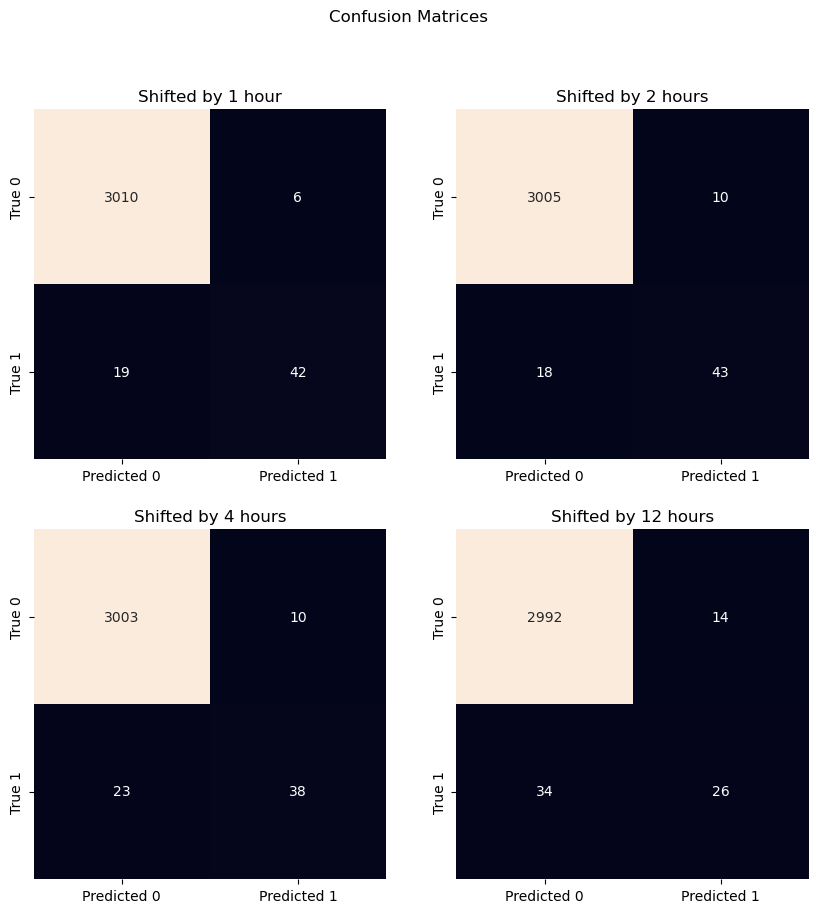

In [62]:
#show all 4 confusion matrices
#show the values in each cell
#also show label "True" and "predcited" as labels for the axis
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Confusion Matrices')
sns.heatmap(cm1, annot=True, ax=axs[0, 0], fmt='g', cbar=False, xticklabels= ['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
sns.heatmap(cm2, annot=True, ax=axs[0, 1], fmt='g', cbar=False, xticklabels= ['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
sns.heatmap(cm4, annot=True, ax=axs[1, 0], fmt='g', cbar=False, xticklabels= ['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
sns.heatmap(cm12, annot=True, ax=axs[1, 1], fmt='g', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
axs[0, 0].set_title('Shifted by 1 hour')
axs[0, 1].set_title('Shifted by 2 hours')
axs[1, 0].set_title('Shifted by 4 hours')
axs[1, 1].set_title('Shifted by 12 hours')
fig.show()

In [63]:
#show f1 scores with plotly grouped bar blots
#show values for each bar

fig = go.Figure(data=[
    go.Bar(name='F1 Score for 0', x=['1 hour', '2 hours', '4 hours', '12 hours'], y=[f1_0_1, f1_0_2, f1_0_4, f1_0_12], text=[f1_0_1, f1_0_2, f1_0_4, f1_0_12], textposition='auto'),
    go.Bar(name='F1 Score for 1', x=['1 hour', '2 hours', '4 hours', '12 hours'], y=[f1_1_1, f1_1_2, f1_1_4, f1_1_12], text=[f1_1_1, f1_1_2, f1_1_4, f1_1_12], textposition='auto')
])
# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

<a id='aufgabe2_fazit'></a>
### Fazit Aufgabe 2

Es lassen sich Störungen in der Zukunft vorhersagen.

Die Erkennung von Normalzuständen kann unabhängig vom Vorhersagezeitraum gut durchgeführt werden. Allerdings nimmt die Fähigkeit, Störungen in der Zukunft zu erkennen, mit dem Anstieg des Vorhersagezeitraums ab. Dies ist auf das Abnehmen der Merkmale zurückzuführen, die auf bevorstehende Störungen hinweisen können, je weiter die Labels vom tatsächlichen Fehlerfall entfernt sind. Trotzdem ist eine Vorhersage von 2 Stunden noch denkbar.

<a id='aufgabe3'></a>

# Aufgabe 3 (Vorhersage der Dauer von Störungen)
    Entwickeln Sie Prognosemodelle zur Vorhersage der Storungsdauer und beurteilen Sie auf geeignete Weise deren Gute sowie deren Eignung für den Einsatz in der Praxis. Sofern diese aus Ihrer Sicht nicht ausreichend ist, skizzieren Sie Maßnahmen, durch die die Gute verbessert werden konnte.

### Lösungsansatz:

Es soll erkannt werden, wie lange eine Störung der APU dauert.
Hierfür wurden 2 Ansätze getestet.

---

#### Ansatz 1: Regression mit kontinuierlichen Labels

Für diesen Ansatz werden die Labels so gesetzt, dass bei normalem Betrieb das Label 0 und während eines Fehlers repräsentiert das Label die verbleibende Dauer in Sekunden bis zur Behebung des Fehlers repräsentiert.

Dieser Ansatz ermöglicht es, einen Regressor auf die Sensormessdaten zu trainieren, um die ungefähre verbleibende Dauer eines Fehlers zu schätzen. Die Verwendung kontinuierlicher Labels ermöglicht es, eine genaue Schätzung der Störungsdauer vorzunehmen, wodurch eine größere Präzision im Vergleich zu einem klassifikatorischen Ansatz erreicht wird. Zudem kann ein Klassifikator die Labels nur in einige festgelegte Klassen einteilen, was zu einer größeren Unschärfe und einer weniger genauen Vorhersage führt. 

---

#### Ansatz 2: Klassifikation mit diskreten Labels

Dieser Ansatz basiert auf einer Klassifikationsanalyse, bei der die Labels diskrete Werte repräsentieren. Ähnlich wie bei dem vorherigen Ansatz wurden die Labels bei normalem Betrieb auf 0 und bei einer Störung auf die verbleibende Dauer bis zur Behebung des Fehlers gesetzt.
Allerdings wurden die Labels in Minuten gruppiert, um eine Klassifikation durchführen zu können. 

Bsp.: X = 5 min
 * 0-5 Minuten = Klasse 1
 * 5-10 Minuten = Klasse 2
 * 10-15 Minuten = Klasse 3
 * ...

Durch die Gruppierung der Labels in Minutenblöcken wurde ein Klassifikator auf das Problem angewendet, um zu schätzen, ob die Störung weniger als X Minuten dauert.
 

<a id='aufgabe3_regression'></a>

---
#### 1. Ansatz: Regression mit kontinuierlichen Labels

In [64]:
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

Labels Setzen mit verbleibender Zeit in Sekunden

In [65]:
df_remaining = pd.read_csv('dataset_train.csv')
df_remaining['timestamp'] = pd.to_datetime(df_remaining['timestamp'])

# Zeiträume für Fehler 1-3 berechnen
err_1_period = (err_1_start, err_1_end)
err_2_period = (err_2_start, err_2_end)
err_3_period = (err_3_start, err_3_end)

# Zeiträume in einer Liste zusammenfassen
failure_periods = [err_1_period, err_2_period, err_3_period]

# Funktion zur Berechnung der verbleibenden Zeit für jedes Zeitintervall
def get_remaining_time(timestamp, failure_periods):
    for start, end in failure_periods:
        if start <= timestamp <= end:
            return (end - timestamp).total_seconds()
    return 0

# Anwenden der Funktion auf jede Zeile des DataFrames
df_remaining['Label'] = df_remaining['timestamp'].apply(lambda x: get_remaining_time(x, failure_periods))

Darstellung der Labels

<AxesSubplot: >

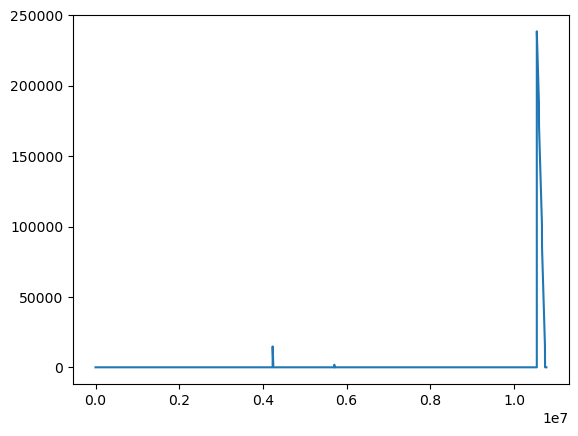

In [66]:
#plot the labels
df_remaining['Label'].plot()

Generiere Datensatz für Training.

Es wird eine kleinere Fenstergröße für Fourier verwendet, um mehr Datensätze zu erhalten.

In [67]:
c = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
X_train, X_test, y_train, y_test =  c.prepareFourier(df_remaining, 512, 0.1,False,False)

Verwendung des Random Forest Regressors.

In [68]:
randReg = RandomForestRegressor(n_estimators=40, max_depth=20, random_state=0, n_jobs=-1)
randReg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=40, n_jobs=-1, random_state=0)

<a id='aufgabe3_regression_res'></a>
Ergebnisse Regression

Plotten der Vorhersage der verbleibenden Zeit VS der tatsächlichen verbleibenden Zeit.

In [69]:
y_pred = randReg.predict(X_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.sort_index(inplace=True)

#plot with plotly
fig = px.line(results, x=results.index, y=["Actual", "Predicted"])
#zoom in on default
fig.update_xaxes(range=[20500, 21040])
fig.show()

#print score
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 1770.0179551631454


Linear Regression

In [70]:
c.fitLinearRegression()
c.linear_regression.predict(c.X_test)
actual = c.y_test.copy()
#reset the index of the actual values
results = pd.DataFrame({'Actual': actual, 'Predicted': c.linear_regression.predict(c.X_test)})
results.sort_index(inplace=True)

#plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=results.index, y=results['Predicted'], name='Predicted'))

#zoom in on default
fig.update_xaxes(range=[20500, 21040])
fig.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(results['Actual'], results['Predicted']))

Mean Absolute Error: 5894.737081953311


Polynomiale Regression wurde auch getestet, jedoch liefert diese schlechtere Ergebnisse.

<a id='aufgabe3_clf'></a>
---
#### 2. Ansatz: Verbleibende Zeit in Klassen aufteilen.
Im zweiten Ansatz werden die Labels, die die verbleibende Zeit bis zum Ende der Störung repräsentieren, in Klassen aufgeteilt. Jede Klasse repräsentiert x verbleibende Minuten. Ein Klassifikator kann dann auf das Problem angewendet werden, aber es ist zu beachten, dass selbst ein perfekter Klassifikator die verbleibende Zeit nur entsprechend der Größe von x vorhersagen kann.

Labels generieren

In [71]:
def generate_labels(df, err_starts, err_ends, x_minutes):
    """
    Generates Labels in a dataframe. The label is the remaining time until the end of the current failure. if there is no failure, the label is 0

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to generate the labels for
    err_starts : list
        A list of datetime objects, which are the start times of the failures
    err_ends : list
        A list of datetime objects, which are the end times of the failures
    x_minutes : int
        The number of minutes to divide the remaining time into
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['Label'] = 0
    
    for i, (err_start, err_end) in enumerate(zip(err_starts, err_ends)):
        condition = (df['timestamp'] > err_start) & (df['timestamp'] <= err_end)
        df.loc[condition, 'Label'] = np.ceil((err_end - df.loc[condition, 'timestamp']).dt.total_seconds() / (60 * x_minutes))
    return df

X_MINUTES = 10
df_remaining = pd.read_csv('dataset_train.csv')
df_remaining = generate_labels(df_remaining, [err_1_start, err_2_start, err_3_start], [err_1_end, err_2_end, err_3_end], X_MINUTES)


In [72]:
df_remaining[(df_remaining['timestamp'] > '2022-03-23 15:00:00') & (df_remaining['timestamp'] <= '2022-03-23 15:24:00')]

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
5706258 2022-03-23 15:00:01 -0.006  9.456  9.458       -0.028       1.588   
5706259 2022-03-23 15:00:02 -0.008  9.456  9.458       -0.028       1.590   
5706260 2022-03-23 15:00:03 -0.006  9.456  9.460       -0.026       1.590   
5706261 2022-03-23 15:00:04 -0.008  9.454  9.456       -0.028       1.588   
5706262 2022-03-23 15:00:05 -0.006  9.456  9.456       -0.028       1.590   
...                     ...    ...    ...    ...          ...         ...   
5707693 2022-03-23 15:23:56 -0.010  8.984  8.990       -0.030       1.590   
5707694 2022-03-23 15:23:57 -0.012  8.982  8.990       -0.030       1.590   
5707695 2022-03-23 15:23:58 -0.010  8.984  8.990       -0.028       1.590   
5707696 2022-03-23 15:23:59 -0.010  8.984  8.990       -0.028       1.592   
5707697 2022-03-23 15:24:00 -0.010  8.984  8.988       -0.028       1.590   

         Oil_temperature  Flowmeter  Motor_current  COMP  DV_eletric  Towers  \
5706258           68.500  19.040281         3.8475     1           0       1   
5706259           68.575  19.049625         3.9225     1           0       1   
5706260           68.575  19.030938         3.8550     1           0       1   
5706261           68.600  19.030938         3.8025     1           0       1   
5706262           68.525  19.030938         3.8875     1           0       1   
...                  ...        ...            ...   ...         ...     ...   
5707693           73.950  19.040281         3.8325     1           0       1   
5707694           74.000  19.049625         3.8275     1           0       1   
5707695           73.900  19.040281         3.9100     1           0       1   
5707696           73.900  19.030938         3.8650     1           0       1   
5707697           73.875  19.012250         3.8075     1           0       1   

         MPG  LPS  Pressure_switch  Oil_level  Caudal_impulses  gpsLong  \
5706258    1    0                0          0                0 -8.69291   
5706259    1    0                0          0                0 -8.69296   
5706260    1    0                0          0                0 -8.69300   
5706261    1    0                0          0                0 -8.69304   
5706262    1    0                0          0                0 -8.69308   
...      ...  ...              ...        ...              ...      ...   
5707693    1    0                0          0                0 -8.67971   
5707694    1    0                0          0                0 -8.67966   
5707695    1    0                0          0                0 -8.67961   
5707696    1    0                0          0                0 -8.67956   
5707697    1    0                0          0                0 -8.67953   

          gpsLat  gpsSpeed  gpsQuality  Label  
5706258  41.1853        21           1      3  
5706259  41.1853        22           1      3  
5706260  41.1853        22           1      3  
5706261  41.1854        21           1      3  
5706262  41.1854        20           1      3  
...          ...       ...         ...    ...  
5707693  41.1804        17           1      1  
5707694  41.1803        18           1      1  
5707695  41.1803        20           1      1  
5707696  41.1803        19           1      1  
5707697  41.1802        17           1      0  

[1440 rows x 22 columns]

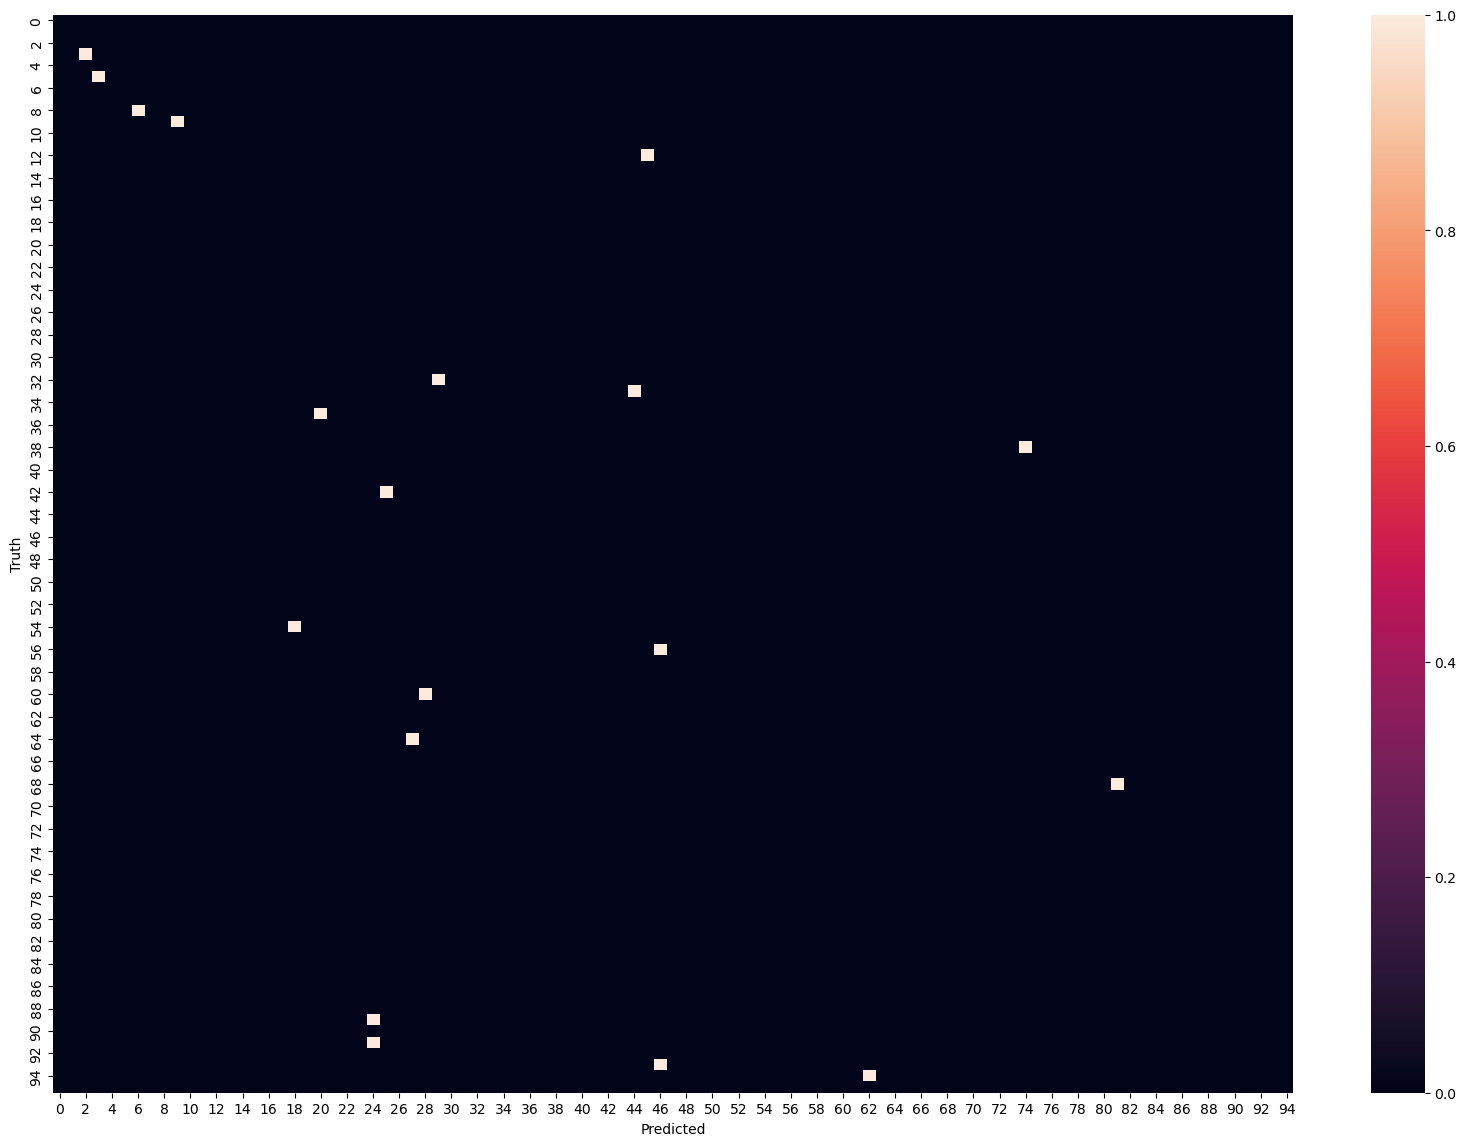

In [73]:
remaining_classifier_fourier = MetroBinaryClassifier(use_shortened=True, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])

# kleinstmögliche Fenstergröße. Bei Kleineren Fenster ist das Frequenzband nicht mehr Hochauflösend genug.
_,_,_,_  = remaining_classifier_fourier.prepareFourier(df_remaining, 512, 0.01,False,True)
remaining_classifier_fourier.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=2)
remaining_classifier_fourier.plotSingleConfusionMatrix(remaining_classifier_fourier.random_forest)

Kleinste Fenstergröße bei Fourier zu groß. Dadurch entstehen zu wenig Datensätze und das Ergebnis ist schlecht.

Verwendung von Sliding Window.

In [74]:
remaining_classifier = MetroBinaryClassifier(use_shortened=True, n_components=0.95, window_size=30, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
_,_,_,_ = remaining_classifier.prepareData(df_remaining, do_scale=True, do_pca=False)

Klassifikatoren Trainieren

In [75]:
# Fit Decision Tree, Random Forest and Logistic Regression
print("Fitting Decision Tree...")
remaining_classifier.fitDecisionTree()
print("Fitting Random Forest ...")
remaining_classifier.fitRandomForest()
print("Fitting Logistic Regression ...")
remaining_classifier.fitLogisticRegression(n_jobs=CPU_CORES)

Fitting Decision Tree...
Fitting Random Forest ...
Fitting Logistic Regression ...


<a id='aufgabe3_clf_res'></a>

Ergebnisse Klassifikation

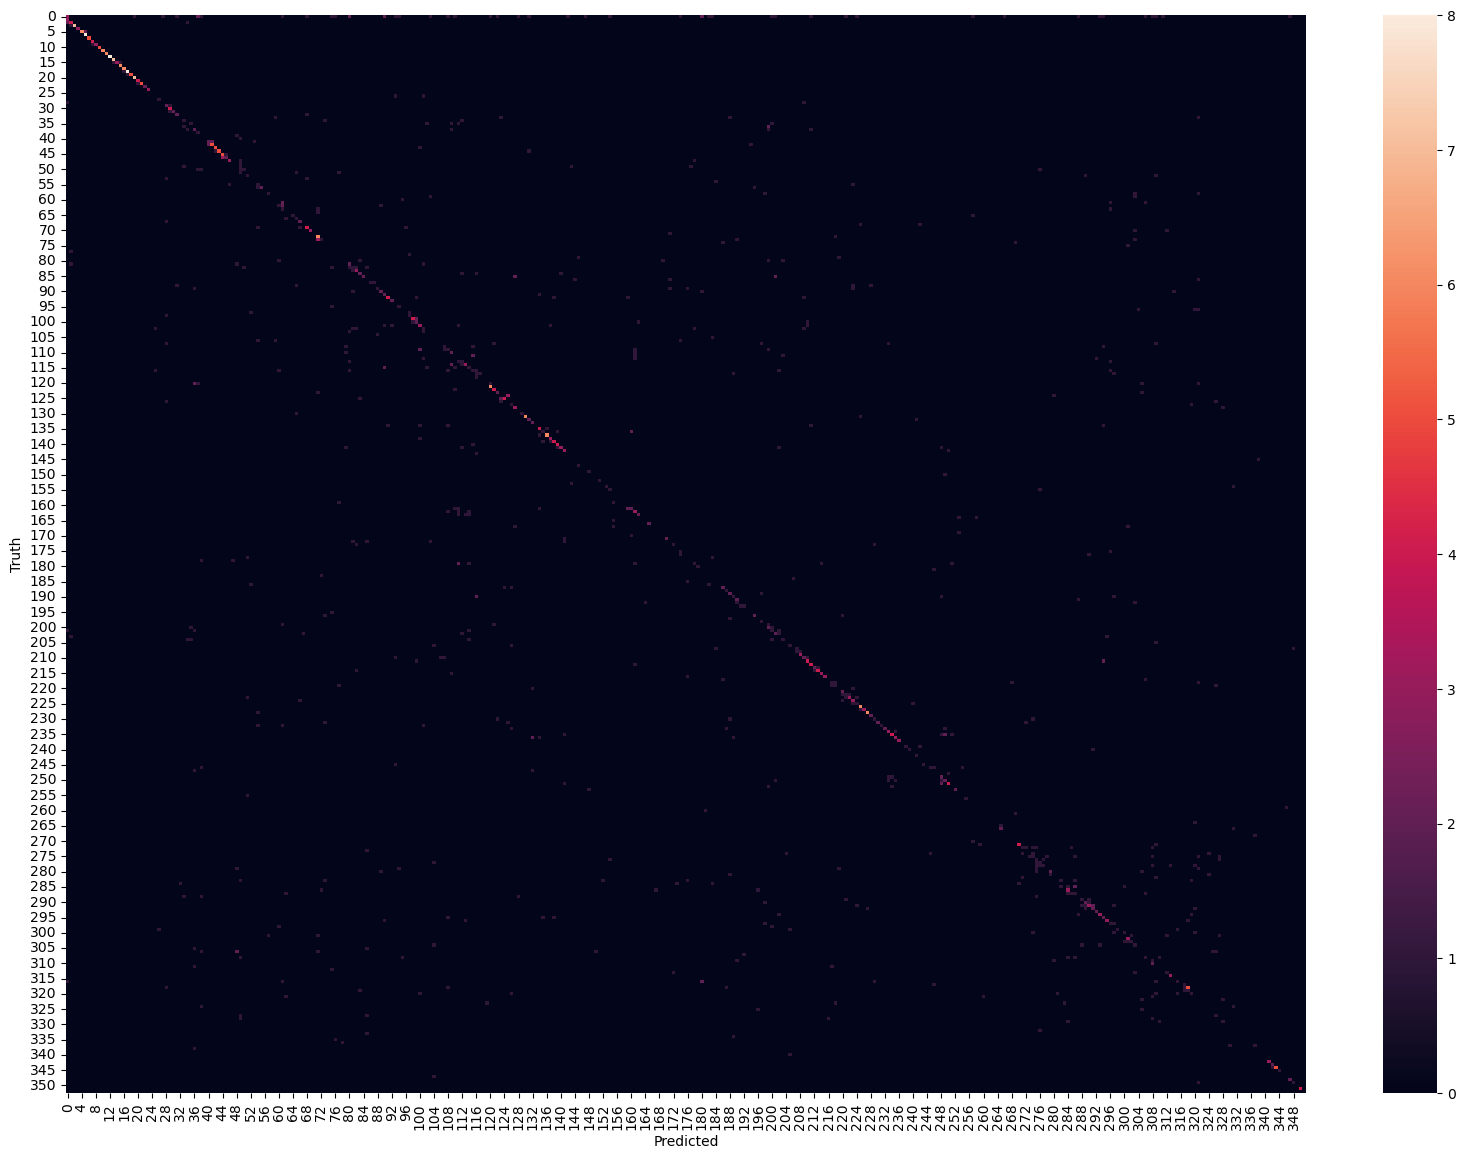

In [76]:
remaining_classifier.plotSingleConfusionMatrix(remaining_classifier.random_forest)

In [77]:
remaining_classifier.plotSingleActualPredicted(remaining_classifier.random_forest, [10_400_000, 10_750_000])

<a id='aufgabe3_fazit'></a>

### Fazit Aufgabe 3

Mit Regression kann kein guter Wert angenähert werden, um die verbleibende Störungsdauer vorherzusagen. Zwar wird relativ gut erkannt, wenn kein Fehler vorliegt, jedoch ist die Vorhersage der verbleibenden Zeit sehr ungenau. Möglicherweise sind die Regressionsmodelle nicht in der Lage, die komplexen Muster und Zusammenhänge, die mit den Störfällen verbunden sind, ausreichend zu trainieren und zu generalisieren.

Eine Alternative ist die Klassifikation, welche zwar bessere Vorhersageergebnisse erzielen kann, aber mit einer geringeren Auflösung (in X-Minuten). Eine Verringerung des Wertes X zur Erhöhung der Auflösung führt zu einer Reduktion der Vorhersagen-Genauigkeit, und umgekehrt.

#### Einsatz in der Praxis

Das Modell könnte in der Praxis funktionieren, aber es wurde nur auf 3 Fehler trainiert und kann daher möglicherweise nur bei diesen Fehlern eine Vorhersage der verbleibenden Dauer treffen. Die Genauigkeit bei Fehler 3 nimmt ab, je länger die verbleibende Dauer ist, was auf einen Mangel an Trainingsdaten für längere Fehlerzeiträume zurückzuführen ist.

Eine optimierte Vorhersagegenauigkeit kann erreicht werden, durch die Entwicklung von getrennten Modellen für jeden Fehlertyp. Es wäre vorteilhaft, eine größere Anzahl von Fehlerzeiträumen für das Training jedes Modells zu nutzen und eine größere Häufigkeit von Fehlerinstanzen für das Training zur Verfügung zu stellen. Hierdurch kann eine Spezialisierung auf die charakteristischen Merkmale eines Fehlers und seiner Restdauer erfolgen.

<a id='aufgabe4'></a>

# Aufgabe 4 (Vorhersage der gestorten Komponente) 
    Untersuchen Sie, ob sich der Datensatz auch dazu eignet, die von einer Storung betroffenen Komponente anhand der Sensordaten zu identifizieren. Erstellen und evaluieren Sie dazu entsprechende Modelle.

### Lösungsansatz:

Die Labels werden für jeden Fehler unterschiedlich gesetzt.

* Für keinen Fehlerfall: Label = 0
* Für Fehler 1: Label = 1
* Für Fehler 2: Label = 2
* Für Fehler 3: Label = 3


In [78]:
def addLabelToData(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    #Start and End of the 3 failures
    err_1_start, err_1_end = dt.datetime(2022,2,28,21,53), dt.datetime(2022,3,1,2,00)
    err_2_start, err_2_end = dt.datetime(2022,3,23,14,54), dt.datetime(2022,3,23,15,24)
    err_3_start, err_3_end = dt.datetime(2022,5,30,12,00), dt.datetime(2022,6,2,6,18)

    #add a label column to the dataframe that is only zeros
    df['Label'] = 0

    #if the data is between err_1_start and err_1_end set the label to 1
    df.loc[(df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end), 'Label'] = 1

    #if the data is between err_2_start and err_2_end set the label to 2
    df.loc[(df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end), 'Label'] = 2

    #if the data is between err_3_start and err_3_end set the label to 3
    df.loc[(df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end), 'Label'] = 3

    return df

In [79]:
#read data from csv, because we need to reassing the labels
df_type = pd.read_csv('dataset_train.csv')
df_type = addLabelToData(df_type)

In [80]:
clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=30, test_size=0.4, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
_,_,_,_ = clf.prepareFourier(df_type,blocksize=600,stratify=True)

In [81]:
# Fit Decision Tree, Random Forest and Logistic Regression
print("Fitting Decision Tree...")
clf.fitDecisionTree()
print("Fitting Random Forest ...")
clf.fitRandomForest()
print("Fitting Logistic Regression ...")
clf.fitLogisticRegression(n_jobs=CPU_CORES)

Fitting Decision Tree...
Fitting Random Forest ...
Fitting Logistic Regression ...


<a id='aufgabe4_res'></a>

### Ergebnisse

In [82]:
clf.evalModels()

In [83]:
clf.ConfusionMatricesis()

Mit der Fourier-Datenbasis können einzelne Fehler erfolgreich unterschieden werden. Allerdings gibt es auch hier ein Problem mit der Größe des Fensters, da dies zu wenig Samples im Fehlerfall erzeugt. Dies führt zu einer ungenauen Klassifizierung von Fehler 2, da es nur einen einzigen Datensatz gibt, der nicht richtig klassifiziert werden kann. Ein kleineres Fenster könnte hier Abhilfe schaffen, aber es ist mit Fourier nicht realisierbar. 

Daher wird das Problem erneut mit dem Sliding Window Ansatz getestet.

In [84]:
clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=30, test_size=0.4, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])

#prepare data
_,_,_,_ = clf.prepareData(df_type, do_scale=True, do_pca=False)

# Fit Decision Tree, Random Forest and Logistic Regression
print("Fitting Decision Tree...")
clf.fitDecisionTree()
print("Fitting Random Forest ...")
clf.fitRandomForest()
print("Fitting Logistic Regression ...")
clf.fitLogisticRegression(n_jobs=CPU_CORES)

Fitting Decision Tree...
Fitting Random Forest ...
Fitting Logistic Regression ...


In [85]:
clf.evalModels()

In [86]:
clf.ConfusionMatricesis()

<a id='aufgabe4_fazit'></a>
### Fazit Aufgabe 4

Ähnlich wie bei den anderen Aufgaben, wird mit den Fourier Daten eine höhere Precision, Recall und F1 erreicht. Allerdings ermöglicht Sliding Window bei dem Decision Tree Klassifikator das Erkennen von Fehler 2, wenn auch mit geringer Genauigkeit.

<a id='aufgabe5'></a>

# Aufgabe 5 (Störungserkennung mit Hilfe von Unsupervised Learning)
    Eine Herausforderung bei der Modellbildung fur Predictive Maintenance ist häufig das Fehlen von Informationen zu historischen Storungen, sodass Ansätze des Supervised Learning nicht anwendbar sind. In diesem Fall konnen Methoden des Unsupervised Learning eine Option sein. Wenden Sie auf den Datensatz aus Aufgabe 1 (ohne Labels) ein Clustering-Verfahren an und überprüfen Sie anhand der gegebenen Informationen zu den historischen Systemausfällen, ob und wie gut sich durch einen solchen Ansatz Ausnahmezustande (Anomalien bzw. Störungen) von "normalen" Systemzustanden der APU unterscheiden lassen.

In [87]:
df = pd.read_csv('dataset_train.csv')
df = addLabelToData(df)

In [88]:
ft = FeatureGeneration()

dff = ft.getFeatures(df,1024,1000,True)

df_normal = dff[dff['Error'] == 0]
df_error1 = dff[dff['Error'] == 1]
df_error2 = dff[dff['Error'] == 2]
df_error3 = dff[dff['Error'] == 3]

#general error
df_erroralg = dff[dff['Error'] != 0]

<a id='aufgabe5_gm_a'></a>

GaussianMixture auf Fourier Daten

In [89]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(dff)


#plot real and predicted labels
#clusters = kmeans.labels_
clusters = gmm.predict(dff)
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=dff.index, y=dff['Error'],
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=dff.index, y=clusters,
                    mode='markers',
                    name='clusters',
                    marker=dict(
                        size=1.5,
                   )))
fig.show()

Die Verwendung von GaussianMixture auf unveränderten Fourier-Daten führt zu starken Störgeräuschen (Rauschen) und ungeeigneten Labels, auch bei einer höheren Anzahl an Clustern.

<a id='aufgabe5_select'></a>

### Lösungsansatz:
Auf Störungen reagieren.

Hierfür muss erst einmal erkannt werden, welche Frequenzen bei Störungen relevant sind. Der Ansatz dies herauszufinden ist, den Datensatz in 4 Datensätze aufzuteilen. Einen für den Normalbetrieb und jeweils einen für jeden Fehler. Dann wird für jeden Sensor und jede Frequenz des Sensors in allen Datensätzen der Durchschnitt und die Standardabweichung berechnet. Dann wird für jede Frequenz der Unterschied zwischen Mittelwert im Normalfall und einem Fehler errechnet. Dadurch lässt sich bestimmen, wie stark die Frequenzen sich im Durchschnitt im Fehlerfall vom Normalfall unterscheiden. Dieser Wert wird letztlich durch die Standardabweichung vom Normalbetrieb geteilt, um so zu bestimmen, wie signifikant die Abweichung ist.

Das Ergebnis wird im unteren Plot dargestellt. In diesem Plot wird anstelle eines speziellen Fehlers der allgemeine Fehlerfall betrachtet. Aus dem Diagramm lässt sich herauslesen, welche Frequenzen besonders stark im Fehlerfall abweichen. Diese Frequenzen werden dann als relevant betrachtet und in den Clustering Algorithmus eingegeben. Die Verwendung von GaussianMixture auf unveränderten Fourier-Daten führt zu starken Störgeräuschen und ungeeigneten Labels, auch bei einer höheren Anzahl an Clustern.

Ein Ansatz, um dieses Problem zu lösen, ist das Herausfinden relevanter Frequenzen, die im Fehlerfall auftreten und davon abweichen. Dies geschieht, indem der Datensatz in 4 Teile aufgeteilt wird: Einen für den Normalbetrieb und jeweils einen für jeden Fehler. Dann wird für jeden Sensor und jede Frequenz durchschnittlicher Wert und Standardabweichung berechnet. Anschließend wird für jede Frequenz der Unterschied zwischen Mittelwert im Normalfall und im Fehlerfall errechnet und durch die Standardabweichung vom Normalbetrieb geteilt, um die Signifikanz der Abweichung zu bestimmen.

Die Ergebnisse werden in einem Plot dargestellt, der den allgemeinen Fehlerfall betrachtet. Aus dem Diagramm lässt sich erkennen, welche Frequenzen im Fehlerfall besonders stark abweichen und werden dann als relevant betrachtet und in den Clustering-Algorithmus eingegeben.

In [90]:
df_normal_stat = df_normal.agg(['mean', 'std'])
df_error1_stat = df_error1.agg(['mean', 'std'])
df_error2_stat = df_error2.agg(['mean', 'std'])
df_error3_stat = df_error3.agg(['mean', 'std'])

#general error case
df_erralg_stat = df_erroralg.agg(['mean', 'std'])

#Um welches vielfaches der Standartabweichung vom Normalbetrieb weichen die Werte der Fehlerfälle vom Normalfall ab.
x = ((df_erralg_stat.loc['mean'] -df_normal_stat.loc['mean'])/df_normal_stat.loc['std']).abs()

fig  = px.line(y=x, x=x.index)

fig.update_layout(
    xaxis_title="Feature",
    yaxis_title="σ",
    title="Signifikanz der Features",
)
fig.show()

Ein Heatmap pro Sensor wird erstellt, um die Abweichungen der Frequenzen im Fehlerfall besser sichtbar zu machen und die Lesbarkeit zu verbessern. Die Werte werden normalisiert, um eine Vergleichbarkeit der Abweichungen bei verschiedenen Sensoren zu gewährleisten.

In [91]:
dff2 = dff.copy()

#only fourier collumns
exclude      = [c for c in dff2.columns if len(c.split("_")) != 2 and c != "Error"]
dff2         = dff2.drop(columns=exclude, axis=1)

In [92]:
#Error and normal cases
dff2_err    = dff2[dff2['Error'] != 0].drop(columns=['Error'], axis=1)
dff2_normal = dff2[dff2['Error'] == 0].drop(columns=['Error'], axis=1)

#calculate mean and std for error
dff2_err_stat    = dff2_err.agg(['mean', 'std'])

#caalculate mean std min and max for normal
dff2_normal_stat = dff2_normal.agg(['mean', 'std', "min", "max"])

#significance is the difference between mean of error and mean of normal divided by std of normal
dff2_sig         = ((dff2_err_stat.loc['mean'] -dff2_normal_stat.loc['mean'])/dff2_normal_stat.loc['std']).agg([abs]).T

#generate a multiindex, by tuples of (feature, frequency)
col_map          = [(c.split("_")[0], int(c.split("_")[1])) for c in dff2_sig.columns]
dff2_sig.columns = pd.MultiIndex.from_tuples(col_map)

#We want the absolute significance
dff2_sig         = dff2_sig.stack(level=0).loc["abs"]


In [93]:
dff2_sig

0         1         2         3         4         5         6    \
H1       0.579349  0.408608  0.425028  0.351167  0.300527  0.270719  0.145367   
MotCurr  0.134320  0.188665  0.186805  0.059353  0.208850  0.159708  0.574576   
Oil      0.126946  0.129459  0.431526  0.634278  1.248418  1.286864  1.538490   
Res      0.842917  0.839864  0.034042  0.289871  0.258096  0.307124  0.364025   
TP3      0.833374  0.590070  0.192282  0.188057  0.288026  0.261540  0.600113   

              7         8         9         10        11        12        13   \
H1       0.061541  0.364428  0.470895  0.169889  0.061492  0.176698  0.228421   
MotCurr  0.305235  0.632347  0.629025  0.626522  0.511076  0.176156  0.148255   
Oil      1.512186  2.053325  2.525580  2.645373  2.655269  2.394003  2.506077   
Res      0.281681  0.331437  0.326736  0.278256  0.272575  0.262137  0.311355   
TP3      0.909337  1.149750  1.501792  1.646816  1.472020  1.156818  1.226645   

              14        15        16        17        18        19        20   \
H1       0.202406  0.199554  0.015193  0.118165  0.097753  0.081476  0.051496   
MotCurr  0.279878  0.084431  0.565868  0.499638  0.501445  0.453240  0.250147   
Oil      2.435167  2.665107  3.075584  2.891655  3.086271  3.213848  3.383074   
Res      0.239137  0.275242  0.270891  0.199830  0.222444  0.248822  0.217710   
TP3      1.189598  1.040160  1.296525  1.443182  1.396231  1.382679  1.659761   

              21        22        23        24        25        26        27   \
H1       0.047201  0.158373  0.153403  0.054661  0.065215  0.006489  0.032349   
MotCurr  0.534799  0.028869  0.434208  0.462216  0.326178  0.502273  0.410548   
Oil      3.180110  3.024088  3.299620  3.046162  3.123810  3.283750  3.334124   
Res      0.203393  0.235566  0.233049  0.190900  0.192866  0.193185  0.154420   
TP3      1.542826  1.340226  1.558398  1.531036  1.478944  1.556664  1.718998   

              28        29        30        31        32        33        34   \
H1       0.016929  0.033291  0.066763  0.027110  0.027584  0.064075  0.030310   
MotCurr  0.606683  0.359143  0.291944  0.536158  0.251465  0.512149  0.552272   
Oil      3.351044  3.202129  3.552840  3.339729  3.281485  3.448974  3.322704   
Res      0.167966  0.127635  0.186194  0.093197  0.135361  0.156919  0.121607   
TP3      1.643988  1.413880  1.675500  1.644655  1.504778  1.637856  1.749816   

              35        36        37        38        39        40        41   \
H1       0.055060  0.083168  0.070010  0.064163  0.081472  0.000347  0.019538   
MotCurr  0.441068  0.331015  0.286969  0.528566  0.360833  0.429455  0.631343   
Oil      3.385946  3.240106  3.543578  3.464790  3.261764  3.528837  3.374730   
Res      0.108586  0.128135  0.164336  0.099713  0.098551  0.086193  0.031969   
TP3      1.585619  1.416989  1.733142  1.777620  1.581603  1.767583  1.849372   

              42        43        44        45        46        47        48   \
H1       0.070769  0.077489  0.095181  0.119721  0.071054  0.063973  0.012143   
MotCurr  0.351165  0.429614  0.338886  0.418712  0.525137  0.496323  0.730272   
Oil      3.465474  3.339188  3.501904  3.532389  3.224816  3.520826  3.448016   
Res      0.098268  0.096593  0.084314  0.070276  0.100021  0.138872  0.092098   
TP3      1.712037  1.573731  1.843669  1.837412  1.499222  1.720955  1.784942   

              49        50        51        52        53        54        55   \
H1       0.017180  0.018100  0.037331  0.016523  0.031471  0.088301  0.123356   
MotCurr  0.412225  0.542969  0.620675  0.356985  0.696119  0.342270  0.481958   
Oil      3.456443  3.417504  3.428906  3.615511  3.269160  3.508894  3.531805   
Res      0.023264  0.036443  0.041801  0.043464  0.076919  0.034578  0.055838   
TP3      1.621198  1.606959  1.846101  1.810846  1.519464  1.819396  1.914256   

              56        57        58        59        60        61        62   \
H1       0.142628  0.129859  0.026999

In [94]:
#Normalize
dff2_sig = dff2_sig.T
dff2_sig = pd.DataFrame(MinMaxScaler().fit_transform(dff2_sig), columns=dff2_sig.columns, index=dff2_sig.index)	
dff2_sig = dff2_sig.T

In [95]:
px.imshow(dff2_sig)

Im Vorfeld einer Analyse kann, falls keine bekannten Fehler vorliegen, aus dem Normalbetrieb Rückschlüsse auf die zu betrachtenden Frequenzen gezogen werden. Hierfür wird ein Balkendiagramm erstellt, das die durchschnittlichen Amplituden für jeden Sensor und jede Frequenz anzeigt. Dieses Balkendiagramm beinhaltet auch die doppelte Standardabweichung vom Durchschnitt sowie die Werte-Spanne.

Ein Balken im Balkendiagramm ist an der Höhe des Durchschnitts angeordnet und seine Größe zeigt die doppelte Standardabweichung in beide Richtungen an. Die Spanne zwischen dem Minimal- und Maximalwert wird mithilfe von Whiskers dargestellt.

Gute Balken zeichnen sich dadurch aus, dass die Whiskers sich nicht weit von der Balkengröße (Standardabweichung) unterscheiden. Da die doppelte Standardabweichung in beide Richtungen dargestellt wird, beinhaltet der Balken Werte, die 95 % der Werte im Normalbetrieb umfassen. Wenn die Whiskers nicht weit von den Balkenenden entfernt sind, sind Abweichungen von den Normalbetriebswerten selten und es kann mit ziemlicher Sicherheit angenommen werden, dass es sich um einen Fehler handelt, wenn ein Wert stark vom Normalbetrieb abweicht.

Ein Beispiel für einen schlechten Balken wäre ein hoher Unterschied zwischen Standardabweichung und Minima/Maxima. Ein Beispiel für einen guten Balken ist bereits oben beschrieben worden.

Beispiel eines schlechten Balkens: <img src="bad bar.png" alt="Alternativtext" title="Titeltext" height="200"/> (Hoher Unterschied zwischen Standardabweichung und Minima/ Maxima)

Beispiel eines guten Balkens: <img src="good bar.png" alt="Alternativtext" title="Titeltext" height="200"/>

In [96]:
#copy to make safe we can rerun the same cell
dff2_normal_stat2   = dff2_normal_stat.copy()

#get a array with tuples representing the the sensor name and the frequency
col_map             = [(c.split("_")[0], int(c.split("_")[1])) for c in dff2_normal_stat2.columns]

#Make Make the Column names a MultiIndex. The first level is the sensor name and the second level is the frequency
dff2_normal_stat2.columns = pd.MultiIndex.from_tuples(col_map)

#Transform so we have first level mean and std and second level the sensor
dff2_normal_gauss = dff2_normal_stat2.stack(level=0).T


df_gauss_stack = dff2_normal_gauss.stack(level=1).reset_index()
df_gauss_stack

level_0  level_1         max        mean           min       std
0           0       H1   19.343677   15.493638  3.431604e-05  1.958608
1           0  MotCurr   10.656582    4.799360  1.636569e-05  2.423145
2           0      Oil  191.999597  134.545022  8.666803e+01  8.485652
3           0      Res    3.785241    3.130003  2.791150e+00  0.179277
4           0      TP3   19.649491   17.950913  5.354371e+00  0.751504
...       ...      ...         ...         ...           ...       ...
2560      512       H1    0.039555    0.005986  2.379743e-08  0.005660
2561      512  MotCurr    0.038147    0.006761  3.571876e-07  0.005062
2562      512      Oil    0.085143    0.002893  6.251759e-07  0.003585
2563      512      Res    0.000595    0.000063  1.359899e-08  0.000048
2564      512      TP3    0.015772    0.000211  6.399867e-09  0.000667

[2565 rows x 6 columns]

In [97]:
# the base is the mean - 2*std
df_gauss_stack["base"]       = df_gauss_stack["mean"]-2*df_gauss_stack["std"]

# the y is the mean + 2*std -> This is to create a bar that is at the hight of the mean and has the size of the std both up and down
df_gauss_stack["y"]          = df_gauss_stack["mean"]+2*df_gauss_stack["std"]    - df_gauss_stack["base"] 

# error_y should be end where the max is and error_y_minus should be the end where the min is
# The error in general should display the range of all values possible values (Between min and max)
# This is why we calculate y_error by subtracing mean and 2*std from max, so the top part of the error bar is the max Value.
df_gauss_stack["error_y"]    = df_gauss_stack["max"]  - df_gauss_stack["mean"]   - 2*df_gauss_stack["std"]
df_gauss_stack["error_y_m"]  = df_gauss_stack["mean"] +  2*df_gauss_stack["std"] - df_gauss_stack["min"]

#Hovertext
df_gauss_stack["text"]  = df_gauss_stack.apply(lambda c: f"Min: {c['min']:.2f} | Mean: {c['mean']:.2f} | Max: {c['max']:.2f} | Std: {c['std']:.2f}", axis=1)
fig = px.bar(df_gauss_stack, x="level_0", base="base", y="y", error_y="error_y", error_y_minus="error_y_m", color="level_1", hover_name="text")

fig.update_xaxes(range=(-1,20))
fig.update_layout(
    xaxis_title="Frequenz",
    yaxis_title="Amplitude",
    title="Amplitudenverteilung der Fourier Features",
)

fig.show()

<a id='aufgabe5_res'></a>
### Ergebnisse

In [98]:
oil_colls = [c for c in dff.columns if c.startswith('Oil')]#[35:200]
tp3_colls = [c for c in dff.columns if c.startswith('TP3')]#[20:]
h1_colls = [c for c in dff.columns if c.startswith('H1')]#[0:2]
res_cols = [c for c in dff.columns if c.startswith('Res')]#[0:2]
mot_curr_colls = [c for c in dff.columns if c.startswith('MotorCurr')]
LPS_colls = [c for c in dff.columns if c.startswith('LPS')]

#filter frequencys
h1 = h1_colls[0:7] + h1_colls[500:]
oil = oil_colls[30:760]
tp3 = tp3_colls[300:]
res = res_cols[0:2]

filter_cols = h1 + oil + tp3  + res

#GMM has yielded best results so far
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(dff[filter_cols])

#get labels
clusters = gmm.predict(dff[filter_cols])

#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=dff.index, y=dff['Error'],
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=dff.index, y=clusters,
                    mode='markers',
                    name='clusters',
                    marker=dict(
                        size=1.5,
                   )))
fig.show()

Sensitivity:  0.9710144927536232


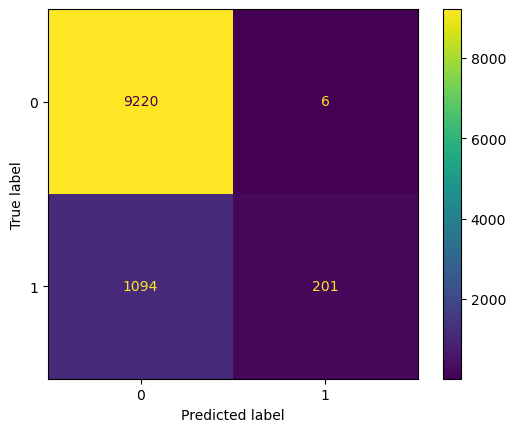

In [99]:
df_res = pd.DataFrame({'Label':dff['Error'], 'Cluster':clusters})
df_res['IsError'] = (df_res['Label'] != 0).astype(int)

#calculate sensitivity (percentage of all errors that are amrked as such)
sens = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 1)).sum()/(df_res["IsError"]==1).sum()

#values for confusion matrix
TP = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 1)).sum()
TN = ((df_res["Cluster"] == 0) & (df_res["IsError"] == 0)).sum()
FP = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 0)).sum()
FN = ((df_res["Cluster"] == 0) & (df_res["IsError"] == 1)).sum()

print("Sensitivity: ", sens)
#make confusion matrix from TP TN FP FN
confusion_matrix = np.array([[TN, FN], [FP, TP]])
#plot confusion matrix with matplotlib ploty
ConfusionMatrixDisplay(confusion_matrix).plot()

<a id='aufgabe5_fazit'></a>
### Fazit Aufgabe 5

Es wurde festgestellt, dass durch die Auswahl relevanter Frequenzen eine gute Erkennung erreicht werden kann. Allerdings wird Fehler 2 unzuverlässig oder verzögert erkannt. Dies kann an einer Verzögerung der Sensorreaktion oder an der Überlappung von Normal- und Fehlerzuständen im Datensatz liegen.

Das Hinzufügen von weiteren Sensoren/Frequenzen führt dazu, dass noch mehr Normalzustände als Fehler erkannt werden. Um bessere Clustering-Ergebnisse zu erzielen, sollte man sich auf eine spezifische Art von Fehler beschränken. Bei der allgemeinen Fehlererkennung ist es jedoch wichtig, auf Sensoren und Frequenzen zu beschränken, die für alle Fehler aussagekräftig sind. Dadurch werden allerdings, wie bereits erwähnt, mehr Normalzustände als Fehler erkannt.

Die vielen erkannten Fehler im Normalzustand können u.U. auf die Unterteilung der Sensorwerte des Normalzustands in mehrere Sub-Zustände (z.B. fahrend, stehend, beschleunigend, bremsend, etc..) zurückgeführt werden. Bei mehreren Clustern im Datensatz wird es schwierig, die Daten in Fehler- und Normalzustände zu trennen.


<a id='src'></a>
# Quellenverzeichniss

[1] https://praxistipps.chip.de/hanning-window-so-funktioniert-es_44003